# TFM - AGUAYO - ENERGY-PRICE CURVE PREDICTION


## 1. INTRODUCTION

In this Notebook a PREDICTED ENERGY-PRICE CURVE model will be created.

The following asumptions will be considered:

+ OMIE energy-price curves from November, 2019 to October, 2020 will be considered as the baseline data information. This info comes from the csv file "OMIE_PALOS1.csv", created previously in "TFM_merged-files.ipynb" notebook.


+ As the information in OMIE file does not consider all 12 blocks for every hourly curve, it is created a new dataframe with 12 blocks for all the curves.


+ Only the following information will be considered as features of the models (X):
    * Weekday
    * Period (hour)
    * Energy offered in the block 24h (one day) before the period considered (MWh)
    * Energy offered in the block 168h (one week) before the period considered (MWh)
   NOTE: In further stages of the project, total demanded energy and fuel gas price will be included as features as well. 
   
   
+ The following information will be considered as targets of the models (y):
    * Energy offered in the block (MWh)
    * Price (€/MWh)
    
    
+ The information from the original OMIE information will be split in the following way:
    * TRAIN SET: November, 2019 - August, 2020. (Note that November will have only 3 weeks, since there are no data for the energy offered one week before the first week of the month.)
    * VALIDATION SET: September, 2020
    * TEST SET: October, 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pd.reset_option('precision')
pd.options.display.float_format = '{:,.2f}'.format

## 2. RETRIEVING, EXPLORING AND PLOTTING OMIE DATA INFORMATION

### 2.1. RETRIEVING DATA INFORMATION

In [3]:
#df will be all data for unit PALOS1 from November 2019 to October 2020. 
#This data was previously created from OMIE web page in "TFM_merged-files.ipynb" notebook.

df_unit = pd.read_csv('/home/dsc/Documents/TFM/Data/OMIE/OMIE_AGUAYO_GEN/OMIE_AGUAYO_GEN.csv',index_col=0)

In [4]:
df_unit.head()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
0,6129555,1,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2020,1,1,1,1,30.00,80.00
1,6129555,1,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2020,1,1,1,2,48.00,80.00
2,6129555,1,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2020,1,1,1,3,52.00,80.00
3,6129555,1,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2020,1,1,1,4,56.00,80.00
4,6129555,1,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2020,1,1,1,5,180.30,40.60


In [5]:
df_unit.shape

(42831, 13)

In [6]:
df_unit.columns

Index(['Bid_Code', 'Num_Version', 'Bid_Unit', 'Unit_Description', 'Sell_Buy',
       'Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price',
       'Energy'],
      dtype='object')

In [7]:
df_unit.tail()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
82127,6126787,2,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2019,12,31,24,1,35.00,80.00
82128,6126787,2,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2019,12,31,24,2,42.00,80.00
82129,6126787,2,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2019,12,31,24,3,47.00,80.00
82130,6126787,2,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2019,12,31,24,4,52.00,80.00
82131,6126787,2,AGUG,C.H. AGUAYO GENERACION,VNO,360.60,2019,12,31,24,5,180.30,40.60


In [8]:
df_unit.describe()

,Bid_Code,Num_Version,Pot_max,Year,Month,Day,Period,Block,Price,Energy
count,"42,831.00","42,831.00","42,831.00","42,831.00","42,831.00","42,831.00","42,831.00","42,831.00","42,831.00","42,831.00"
mean,"6,295,874.96",1.86,360.60,"2,019.83",6.51,15.72,12.49,2.95,67.44,71.51
std,"146,607.31",1.11,0.00,0.38,3.45,8.78,6.93,1.40,53.26,20.51
min,"6,051,654.00",0.00,360.60,"2,019.00",1.00,1.00,1.00,1.00,2.20,0.60
25%,"6,168,916.00",1.00,360.60,"2,020.00",4.00,8.00,6.00,2.00,36.00,60.60
50%,"6,291,789.00",2.00,360.60,"2,020.00",6.00,16.00,12.00,3.00,48.00,80.00
75%,"6,421,067.00",3.00,360.60,"2,020.00",10.00,23.00,18.00,4.00,61.00,80.00
max,"6,557,010.00",5.00,360.60,"2,020.00",12.00,31.00,25.00,5.00,180.30,220.00


In [9]:
df_unit.dtypes

Bid_Code              int64
Num_Version           int64
Bid_Unit             object
Unit_Description     object
Sell_Buy             object
Pot_max             float64
Year                  int64
Month                 int64
Day                   int64
Period                int64
Block                 int64
Price               float64
Energy              float64
dtype: object

In [10]:
#Picking only the information that will be needed for ploting the bid curve.

df_curve = df_unit[['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price',
       'Energy']]

In [11]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy
0,360.60,2020,1,1,1,1,30.00,80.00
1,360.60,2020,1,1,1,2,48.00,80.00
2,360.60,2020,1,1,1,3,52.00,80.00
3,360.60,2020,1,1,1,4,56.00,80.00
4,360.60,2020,1,1,1,5,180.30,40.60


In [12]:
#Including date and week day per each day.

import datetime as dt

df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])

<ipython-input-12-5b7c39998bb0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])


In [13]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date
0,360.60,2020,1,1,1,1,30.00,80.00,2020-01-01
1,360.60,2020,1,1,1,2,48.00,80.00,2020-01-01
2,360.60,2020,1,1,1,3,52.00,80.00,2020-01-01
3,360.60,2020,1,1,1,4,56.00,80.00,2020-01-01
4,360.60,2020,1,1,1,5,180.30,40.60,2020-01-01


In [14]:
df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())


<ipython-input-14-89fa5e36ee21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())


In [15]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday
0,360.60,2020,1,1,1,1,30.00,80.00,2020-01-01,2
1,360.60,2020,1,1,1,2,48.00,80.00,2020-01-01,2
2,360.60,2020,1,1,1,3,52.00,80.00,2020-01-01,2
3,360.60,2020,1,1,1,4,56.00,80.00,2020-01-01,2
4,360.60,2020,1,1,1,5,180.30,40.60,2020-01-01,2


In [16]:
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

df_curve['Weekday'] = df_curve['Weekday'].apply(lambda x: weekDays[x])

<ipython-input-16-ad44a60512b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Weekday'] = df_curve['Weekday'].apply(lambda x: weekDays[x])


In [17]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday
0,360.60,2020,1,1,1,1,30.00,80.00,2020-01-01,Wednesday
1,360.60,2020,1,1,1,2,48.00,80.00,2020-01-01,Wednesday
2,360.60,2020,1,1,1,3,52.00,80.00,2020-01-01,Wednesday
3,360.60,2020,1,1,1,4,56.00,80.00,2020-01-01,Wednesday
4,360.60,2020,1,1,1,5,180.30,40.60,2020-01-01,Wednesday


In [18]:
#Including the total Energy for all blocks in a certain hour

df_curve['Energy_tot'] = df_curve.groupby(['Date','Period'])['Energy'].cumsum()

<ipython-input-18-59be226ee6af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Energy_tot'] = df_curve.groupby(['Date','Period'])['Energy'].cumsum()


In [19]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2020,1,1,1,1,30.00,80.00,2020-01-01,Wednesday,80.00
1,360.60,2020,1,1,1,2,48.00,80.00,2020-01-01,Wednesday,160.00
2,360.60,2020,1,1,1,3,52.00,80.00,2020-01-01,Wednesday,240.00
3,360.60,2020,1,1,1,4,56.00,80.00,2020-01-01,Wednesday,320.00
4,360.60,2020,1,1,1,5,180.30,40.60,2020-01-01,Wednesday,360.60


In [20]:
df_curve = df_curve.sort_values(['Date','Period','Block']).reset_index(drop=True)

In [21]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60


In [22]:
#Checkings to be moved to other places in the document
df_curve[df_curve['Price']!=df_curve['Price'].max()]['Price'].max()

100.0

In [23]:
df_curve[df_curve['Price']==df_curve[df_curve['Price']!=df_curve['Price'].max()]['Price'].max()]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
9116,360.60,2020,1,17,1,5,100.00,40.60,2020-01-17,Friday,360.60
9121,360.60,2020,1,17,2,5,100.00,40.60,2020-01-17,Friday,360.60
9126,360.60,2020,1,17,3,5,100.00,40.60,2020-01-17,Friday,360.60
9131,360.60,2020,1,17,4,5,100.00,40.60,2020-01-17,Friday,360.60
9136,360.60,2020,1,17,5,5,100.00,40.60,2020-01-17,Friday,360.60
...,...,...,...,...,...,...,...,...,...,...,...
36881,360.60,2020,9,10,14,4,100.00,19.20,2020-09-10,Thursday,179.20
36885,360.60,2020,9,10,15,4,100.00,19.20,2020-09-10,Thursday,179.20
36889,360.60,2020,9,10,16,4,100.00,19.20,2020-09-10,Thursday,179.20
36893,360.60,2020,9,10,17,4,100.00,19.20,2020-09-10,Thursday,179.20


In [24]:
df_curve[df_curve['Price']!=df_curve['Price'].min()]['Price'].min()

2.35

In [25]:
#Storing the DataFrame locally
df_curve.to_csv('/home/dsc/Repos/TFM/AGUAYO_DataFrame.csv')

### 2.2. EXPLORING DATA INFORMATION

In [26]:
#Searching for NaN

if df_unit.shape[0] == df_unit.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [27]:
#Function created for showing for a certain day and hour of df_curve

def date_hour_info(date, hour):
    return df_curve[(df_curve['Date']==date) & (df_curve['Period']==hour)]

In [28]:
date_hour_info('2020-10-31',1)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
42711,360.60,2020,10,31,1,1,35.00,80.00,2020-10-31,Saturday,80.00
42712,360.60,2020,10,31,1,2,45.00,80.00,2020-10-31,Saturday,160.00
42713,360.60,2020,10,31,1,3,55.00,80.00,2020-10-31,Saturday,240.00
42714,360.60,2020,10,31,1,4,65.00,80.00,2020-10-31,Saturday,320.00
42715,360.60,2020,10,31,1,5,180.30,40.60,2020-10-31,Saturday,360.60


In [29]:
#Checking that hour 23 and 24 are exactly the same for one day
#A GENERAL CHECKING TO BE INCLUDED

np.array(date_hour_info('2020-10-31',24)['Price']) == np.array(date_hour_info('2020-10-31',23)['Price'])

array([ True,  True,  True,  True,  True])

In [30]:
date_hour_info('2020-10-25',1)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
41986,360.60,2020,10,25,1,1,26.20,80.00,2020-10-25,Sunday,80.00
41987,360.60,2020,10,25,1,2,30.20,60.00,2020-10-25,Sunday,140.00
41988,360.60,2020,10,25,1,3,33.20,60.00,2020-10-25,Sunday,200.00
41989,360.60,2020,10,25,1,4,45.20,120.00,2020-10-25,Sunday,320.00
41990,360.60,2020,10,25,1,5,180.30,40.60,2020-10-25,Sunday,360.60


In [31]:
############# CHECKING DATA FROM df_curve  #############################################

In [32]:
df_curve.shape

(42831, 11)

In [203]:
df_curve[df_curve['Block']==1].shape 

(8784, 11)

In [204]:
df_curve[df_curve['Block']==1].shape[0]/24

366.0

In [240]:
df_curve[df_curve['Block']==5].shape[0]/24

324.9583333333333

In [35]:
#Something is wrong if the number above is not an integer

In [36]:
from datetime import datetime

first_day = datetime(df_curve['Date'].min().year,
                  df_curve['Date'].min().month,
                  df_curve['Date'].min().day)

last_day = datetime(df_curve['Date'].max().year,
                  df_curve['Date'].max().month,
                  df_curve['Date'].max().day)

In [37]:
#Checking the number of years
num_years = len(df_curve['Year'].value_counts())
num_years

2

In [38]:
#Number of missing years in the original data

num_years_real = (last_day.year - first_day.year) + 1
diff_num_years = num_years_real - num_years
diff_num_years

0

In [39]:
#Checking the number of months in the original data

num_months = len(df_curve[['Year','Month']].value_counts())
num_months

12

In [40]:
#Number of missing months in the original data

num_months_real = (last_day.month -first_day.month) + 12*(last_day.year - first_day.year) + 1
diff_num_months = num_months_real - num_months
diff_num_months

0

In [41]:
#Checking the number of days in the original data

num_days = len(df_curve['Date'].value_counts())
num_days

366

In [42]:
df_curve['Date'].min()

Timestamp('2019-11-01 00:00:00')

In [43]:
df_curve['Date'].max()

Timestamp('2020-10-31 00:00:00')

In [44]:
num_days_real = (last_day - first_day).days + 1
num_days_real

366

In [45]:
#Number of missing days in original data
diff_days = num_days_real - num_days
diff_days

0

In [46]:
#Checking the number of hours in the original data

num_hours_real = num_days_real*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_real


8784

In [47]:
num_hours_orig_real = num_days*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_orig_real

8784

In [48]:
#Checking the number of hours

num_hours = df_curve.groupby(['Date','Period'])['Block'].count().value_counts().sum()
num_hours

8784

In [49]:
#Number of missing hours from the original data
diff_hours = num_hours_real - num_hours
diff_hours

0

In [50]:
#Number of missing hours from the days in the original data
diff_hours_orig = num_hours_orig_real - num_hours
diff_hours_orig

0

In [51]:
#Number of hours per each block. We can see that the only block that appears in all periods is BLOCK 12.
df_curve.groupby(['Block'])['Period'].count()

Block
1    8784
2    8784
3    8768
4    8696
5    7799
Name: Period, dtype: int64

In [53]:
#Variable to include the number of the block that appears always (if there are more than one the minimum is chosen).
serie_block_all = df_curve.groupby(['Block'])['Period'].count()[df_curve.groupby(['Block'])['Period'].count() == num_hours]
serie_block_all = serie_block_all.reset_index()
block_all = serie_block_all['Block'].min()
block_all

1

In [54]:
#Checking that every day has 23, 24 or 25 hours
#We know that all periods have at least the block with the number equal to block_all

df_curve_hours = df_curve[(df_curve['Block']==block_all)].groupby('Date')['Period'].count()
df_curve_hours

Date
2019-11-01    24
2019-11-02    24
2019-11-03    24
2019-11-04    24
2019-11-05    24
              ..
2020-10-27    24
2020-10-28    24
2020-10-29    24
2020-10-30    24
2020-10-31    24
Name: Period, Length: 366, dtype: int64

In [55]:
#Number of days with 23h, 24h, 25h or less
df_curve_hours.value_counts()

24    364
25      1
23      1
Name: Period, dtype: int64

In [56]:
#Day with less than 23 hours
df_curve_hours[(df_curve_hours != 23) & (df_curve_hours != 24) & (df_curve_hours != 25)]

Series([], Name: Period, dtype: int64)

In [57]:
#Checking data in a period of time
df_curve.loc[df_curve['Date'].isin(['2019-11-05','2019-11-17'])]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
480,360.60,2019,11,5,1,1,32.00,80.00,2019-11-05,Tuesday,80.00
481,360.60,2019,11,5,1,2,34.00,80.00,2019-11-05,Tuesday,160.00
482,360.60,2019,11,5,1,3,39.00,80.00,2019-11-05,Tuesday,240.00
483,360.60,2019,11,5,1,4,42.00,80.00,2019-11-05,Tuesday,320.00
484,360.60,2019,11,5,1,5,180.30,40.60,2019-11-05,Tuesday,360.60
...,...,...,...,...,...,...,...,...,...,...,...
2035,360.60,2019,11,17,24,1,50.00,80.00,2019-11-17,Sunday,80.00
2036,360.60,2019,11,17,24,2,54.00,80.00,2019-11-17,Sunday,160.00
2037,360.60,2019,11,17,24,3,62.00,80.00,2019-11-17,Sunday,240.00
2038,360.60,2019,11,17,24,4,64.00,80.00,2019-11-17,Sunday,320.00


In [58]:
#Searching the days with 23h and 25h within the original data period. 
#It is known that in Spain times changes from 2am to 3am every last Sunday of March and 
#from 3am to 2am every last Sunday of October

from datetime import datetime, timedelta

start_year = df_curve['Year'].min()
end_year = df_curve['Year'].max()

days_23h = []
days_25h = []

for yx in range(start_year,end_year+1):
    
    m_min = df_curve['Month'][df_curve['Year']==yx].min()
    m_max = df_curve['Month'][df_curve['Year']==yx].max()
    
    if 10 in range(m_min,m_max+1):
        October_date = datetime(yx,10,31)
        offset_October = (October_date.weekday() - 6)%7
        last_October_sunday = October_date - timedelta(days=offset_October)
        days_25h += [last_October_sunday]
 
    if 3 in range(m_min,m_max+1):
        March_date = datetime(yx,3,31)
        offset_March = (March_date.weekday() - 6)%7
        last_March_sunday = March_date - timedelta(days=offset_March)
        days_23h += [last_March_sunday]

print(days_25h)
print(days_23h)

[datetime.datetime(2020, 10, 25, 0, 0)]
[datetime.datetime(2020, 3, 29, 0, 0)]


In [59]:
days_25h[0]

datetime.datetime(2020, 10, 25, 0, 0)

In [60]:
#View of some expamples of bids per hour

In [61]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
41986,360.60,2020,10,25,1,1,26.20,80.00,2020-10-25,Sunday,80.00
41987,360.60,2020,10,25,1,2,30.20,60.00,2020-10-25,Sunday,140.00
41988,360.60,2020,10,25,1,3,33.20,60.00,2020-10-25,Sunday,200.00
41989,360.60,2020,10,25,1,4,45.20,120.00,2020-10-25,Sunday,320.00
41990,360.60,2020,10,25,1,5,180.30,40.60,2020-10-25,Sunday,360.60
41991,360.60,2020,10,25,2,1,26.20,80.00,2020-10-25,Sunday,80.00
41992,360.60,2020,10,25,2,2,30.20,60.00,2020-10-25,Sunday,140.00
41993,360.60,2020,10,25,2,3,33.20,60.00,2020-10-25,Sunday,200.00
41994,360.60,2020,10,25,2,4,45.20,120.00,2020-10-25,Sunday,320.00
41995,360.60,2020,10,25,2,5,180.30,40.60,2020-10-25,Sunday,360.60


In [62]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
17544,360.60,2020,3,29,1,1,25.00,80.00,2020-03-29,Sunday,80.00
17545,360.60,2020,3,29,1,2,28.00,80.00,2020-03-29,Sunday,160.00
17546,360.60,2020,3,29,1,3,31.00,80.00,2020-03-29,Sunday,240.00
17547,360.60,2020,3,29,1,4,35.00,60.00,2020-03-29,Sunday,300.00
17548,360.60,2020,3,29,1,5,180.30,60.60,2020-03-29,Sunday,360.60
17549,360.60,2020,3,29,2,1,25.00,80.00,2020-03-29,Sunday,80.00
17550,360.60,2020,3,29,2,2,28.00,80.00,2020-03-29,Sunday,160.00
17551,360.60,2020,3,29,2,3,31.00,80.00,2020-03-29,Sunday,240.00
17552,360.60,2020,3,29,2,4,35.00,60.00,2020-03-29,Sunday,300.00
17553,360.60,2020,3,29,2,5,180.30,60.60,2020-03-29,Sunday,360.60


In [63]:
#View of some expamples of bids per hour

In [64]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([6,7,8]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
42011,360.60,2020,10,25,6,1,26.20,80.00,2020-10-25,Sunday,80.00
42012,360.60,2020,10,25,6,2,30.20,60.00,2020-10-25,Sunday,140.00
42013,360.60,2020,10,25,6,3,33.20,60.00,2020-10-25,Sunday,200.00
42014,360.60,2020,10,25,6,4,45.20,120.00,2020-10-25,Sunday,320.00
42015,360.60,2020,10,25,6,5,180.30,40.60,2020-10-25,Sunday,360.60
42016,360.60,2020,10,25,7,1,26.20,80.00,2020-10-25,Sunday,80.00
42017,360.60,2020,10,25,7,2,30.20,60.00,2020-10-25,Sunday,140.00
42018,360.60,2020,10,25,7,3,33.20,60.00,2020-10-25,Sunday,200.00
42019,360.60,2020,10,25,7,4,45.20,120.00,2020-10-25,Sunday,320.00
42020,360.60,2020,10,25,7,5,180.30,40.60,2020-10-25,Sunday,360.60


In [65]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([6,7,8]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
17569,360.60,2020,3,29,6,1,23.00,80.00,2020-03-29,Sunday,80.00
17570,360.60,2020,3,29,6,2,26.00,80.00,2020-03-29,Sunday,160.00
17571,360.60,2020,3,29,6,3,29.00,80.00,2020-03-29,Sunday,240.00
17572,360.60,2020,3,29,6,4,33.00,60.00,2020-03-29,Sunday,300.00
17573,360.60,2020,3,29,6,5,180.30,60.60,2020-03-29,Sunday,360.60
17574,360.60,2020,3,29,7,1,23.00,80.00,2020-03-29,Sunday,80.00
17575,360.60,2020,3,29,7,2,26.00,80.00,2020-03-29,Sunday,160.00
17576,360.60,2020,3,29,7,3,28.00,80.00,2020-03-29,Sunday,240.00
17577,360.60,2020,3,29,7,4,32.00,60.00,2020-03-29,Sunday,300.00
17578,360.60,2020,3,29,7,5,180.30,60.60,2020-03-29,Sunday,360.60


In [66]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([9,10]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
42026,360.60,2020,10,25,9,1,26.20,80.00,2020-10-25,Sunday,80.00
42027,360.60,2020,10,25,9,2,29.20,60.00,2020-10-25,Sunday,140.00
42028,360.60,2020,10,25,9,3,32.20,60.00,2020-10-25,Sunday,200.00
42029,360.60,2020,10,25,9,4,44.20,120.00,2020-10-25,Sunday,320.00
42030,360.60,2020,10,25,9,5,180.30,40.60,2020-10-25,Sunday,360.60
42031,360.60,2020,10,25,10,1,26.20,80.00,2020-10-25,Sunday,80.00
42032,360.60,2020,10,25,10,2,29.20,60.00,2020-10-25,Sunday,140.00
42033,360.60,2020,10,25,10,3,32.20,60.00,2020-10-25,Sunday,200.00
42034,360.60,2020,10,25,10,4,44.20,120.00,2020-10-25,Sunday,320.00
42035,360.60,2020,10,25,10,5,180.30,40.60,2020-10-25,Sunday,360.60


In [67]:
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([9,10]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
17584,360.60,2020,3,29,9,1,15.00,80.00,2020-03-29,Sunday,80.00
17585,360.60,2020,3,29,9,2,18.00,80.00,2020-03-29,Sunday,160.00
17586,360.60,2020,3,29,9,3,20.00,80.00,2020-03-29,Sunday,240.00
17587,360.60,2020,3,29,9,4,24.00,60.00,2020-03-29,Sunday,300.00
17588,360.60,2020,3,29,9,5,180.30,60.60,2020-03-29,Sunday,360.60
17589,360.60,2020,3,29,10,1,15.00,80.00,2020-03-29,Sunday,80.00
17590,360.60,2020,3,29,10,2,18.00,80.00,2020-03-29,Sunday,160.00
17591,360.60,2020,3,29,10,3,20.00,80.00,2020-03-29,Sunday,240.00
17592,360.60,2020,3,29,10,4,24.00,60.00,2020-03-29,Sunday,300.00
17593,360.60,2020,3,29,10,5,180.30,60.60,2020-03-29,Sunday,360.60


In [68]:
############ CELLS BELOW UP TO POINT 2.3 SHOULD BE DELETED ####################

In [69]:
#Checking the number or hours per date
df_curve.groupby(['Year','Month','Day'])['Period'].count()

Year  Month  Day
2019  11     1      120
             2      120
             3      120
             4      120
             5      120
                   ... 
2020  10     27     120
             28     120
             29     120
             30     120
             31     120
Name: Period, Length: 366, dtype: int64

In [72]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==1)].value_counts('Day')

Day
16    12
15    12
2     12
3     12
4     12
5     12
6     12
7     12
8     12
9     12
10    12
11    12
12    12
13    12
14    12
1     12
17    12
18    12
19    12
20    12
21    12
22    12
23    12
24    12
25    12
26    12
27    12
28    12
30    11
29    11
31     7
dtype: int64

In [73]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==1)&
                                                  (df_curve['Day']==2)]

,Year,Month,Day,Period,Block
235,2019,11,2,24,1
3835,2019,12,2,24,1
7491,2020,1,2,24,1
10939,2020,2,2,24,1
14419,2020,3,2,24,1
18134,2020,4,2,24,1
21734,2020,5,2,24,1
25454,2020,6,2,24,1
29023,2020,7,2,24,1
32493,2020,8,2,24,1


In [74]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==1)&
                                                  (df_curve['Month']==11)]

,Year,Month,Day,Period,Block
115,2019,11,1,24,1
235,2019,11,2,24,1
355,2019,11,3,24,1
475,2019,11,4,24,1
595,2019,11,5,24,1
715,2019,11,6,24,1
835,2019,11,7,24,1
955,2019,11,8,24,1
1075,2019,11,9,24,1
1195,2019,11,10,24,1


In [75]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==1)&
                                                  (df_curve['Month']==11)].shape

(30, 5)

In [76]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Block']==1)&
                                                  (df_curve['Month']==11)].shape

(720, 5)

In [78]:
df_curve[['Year','Month','Day','Period','Block']][(df_curve['Period']==24)&
                                                  (df_curve['Block']==1)&
                                                  (df_curve['Day']==5)]

,Year,Month,Day,Period,Block
595,2019,11,5,24,1
4132,2019,12,5,24,1
7851,2020,1,5,24,1
11299,2020,2,5,24,1
14779,2020,3,5,24,1
18494,2020,4,5,24,1
22094,2020,5,5,24,1
25814,2020,6,5,24,1
29383,2020,7,5,24,1
32853,2020,8,5,24,1


In [79]:
#Checking the number or blocks per date and period
df_curve.groupby(['Year','Month','Day','Period'])['Block'].count()

Year  Month  Day  Period
2019  11     1    1         5
                  2         5
                  3         5
                  4         5
                  5         5
                           ..
2020  10     31   20        5
                  21        5
                  22        5
                  23        5
                  24        5
Name: Block, Length: 8784, dtype: int64

In [80]:
#Checking the number of hours with a certain number of blocks. It can be seen that most of them have 12 blocks,
#but there are a lot of hours with only one or two blocks.
df_curve.groupby(['Year','Month','Day','Period'])['Block'].count().value_counts()

5    7799
4     897
3      72
2      16
Name: Block, dtype: int64

In [81]:
#Checking the number of hours in one year
len(df_curve.groupby(['Year','Month','Day','Period'])['Block'].count())

8784

In [85]:
len(df_curve.groupby(['Year','Month','Day','Period'])['Block'].count())/24

366.0

In [86]:
#Number of missing days
366 -len(df_curve.groupby(['Year','Month','Day','Period'])['Block'].count())/24

0.0

In [87]:
df_curve.groupby(['Month','Day','Period'])['Block'].count().value_counts().sum()

8784

In [88]:
len(df_curve)

42831

In [89]:
df_curve[['Month','Day','Block']].groupby(['Block']).count()

,Month,Day
Block,,
1,8784,8784
2,8784,8784
3,8768,8768
4,8696,8696
5,7799,7799


In [90]:
df_curve[['Month','Day','Block']].groupby(['Block']).count().sum()

Month    42831
Day      42831
dtype: int64

In [91]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60


### 2.3. PLOTTING DATA INFORMATION

In [92]:
#Function to plot bid curves for a chosen dataframe, date and period (hour)

def plot_bid_curve(dataframe, date, hour):
    df_plot = dataframe[(dataframe['Date'] == date) & (dataframe['Period'] == hour)]
    return plt.plot(pd.Series(0).append(df_plot['Energy_tot']), 
                    pd.Series(df_plot['Price'].iloc[0]).append(df_plot['Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)')

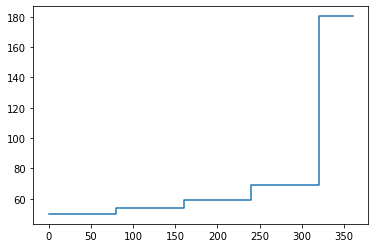

In [93]:
plot_bid_curve(df_curve, '2020-10-31', 24)

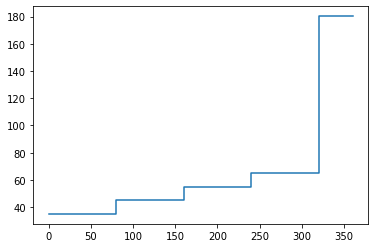

In [94]:
plot_bid_curve(df_curve,'2020-10-31', 1)

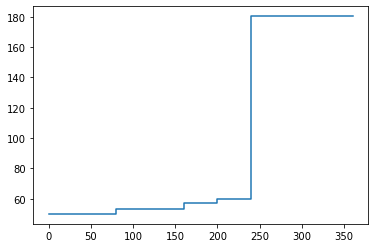

In [95]:
plot_bid_curve(df_curve,'2020-8-25', 1)

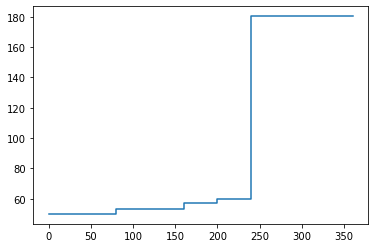

In [96]:
plot_bid_curve(df_curve,'2020-8-25',4)

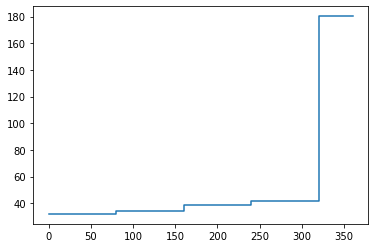

In [97]:
plot_bid_curve(df_curve,'2019-11-5',4)

In [98]:
df_curve[(df_curve['Date'] == '2019-11-9') & (df_curve['Period'] == 4)]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
975,360.60,2019,11,9,4,1,50.00,80.00,2019-11-09,Saturday,80.00
976,360.60,2019,11,9,4,2,53.50,80.00,2019-11-09,Saturday,160.00
977,360.60,2019,11,9,4,3,57.00,80.00,2019-11-09,Saturday,240.00
978,360.60,2019,11,9,4,4,60.50,80.00,2019-11-09,Saturday,320.00
979,360.60,2019,11,9,4,5,180.30,40.60,2019-11-09,Saturday,360.60


## 3. DATA WRANGLING

### 3.1. CREATING A NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR

In this section a new dataframe will be created from the original one by completing the information por every hour that does not have all blocks (12). 

It is important to point out that in the original dataframe does not have 12 blocks per each hour (or period), since not always is necessary in the biding curve. In order to use the information in the models that will be created, it is important that every hour is divided in 12 blocks. 

As the original dataframe does not have all days and hours for a given period, it is decided to create a new dataframe equal to the original one (only for dates, hours and blocks) but with all 12 blocks per each hour in the orignal data.

The new dataframe is created considering a df structure for 1 Block and then copy this new df, changing the number of the block and appending it to the original. The correct structure of the df will be created by doing it 12 times.

Then this new dataframe will be merged with the original one so NaN will be created for all the columns without blocks in the original dataframe. This NaN will be filled depending on each case.

In [99]:
#Checking blocks for one day
date_hour_info('2020-10-22',9)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
41666,360.60,2020,10,22,9,1,42.00,80.00,2020-10-22,Thursday,80.00
41667,360.60,2020,10,22,9,2,46.00,40.00,2020-10-22,Thursday,120.00
41668,360.60,2020,10,22,9,3,48.00,40.00,2020-10-22,Thursday,160.00
41669,360.60,2020,10,22,9,4,56.00,80.00,2020-10-22,Thursday,240.00
41670,360.60,2020,10,22,9,5,180.30,120.60,2020-10-22,Thursday,360.60


### 3.1.1. MODIFYING THE ORIGINAL DATAFRAME TO REMOVE DAYS WITH 23H AND 25H


In [100]:
#New dataframe is created considering 24h for all days
df_curve_24h = df_curve.copy()

In [101]:
#Funtions needed for renaming periods in 23h-days and 25h-days.

def change_25h_to24h(x):
    if x >= 4:
        x -= 1
    return x

def change_23h_to24h(x):
    if x >= 2:
        x += 1
    return x

In [102]:
#Transforming 25h-day into 24h-day.

for date_25h in days_25h:
    #dataframe only with 25h-day data
    df_curve_day25h = df_curve_24h[df_curve_24h['Date']==date_25h]
    #Deleting period 3 from 25h-days.
    df_curve_day25h = df_curve_day25h.drop(df_curve_day25h.loc[df_curve_day25h['Period']==3].index)
    #Renaming periods from 4 to 25 to 3 to 24
    df_curve_day25h['Period'] = df_curve_day25h['Period'].apply(change_25h_to24h)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_25h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day25h])

In [103]:
#Transforming 23h-day into 24h-day.

for date_23h in days_23h:
    df_curve_day23h = df_curve_24h[df_curve_24h['Date']==date_23h]
    #Renaming periods from 2 to 23 to 3 to 24
    df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
    #Copying period 1 as period 2 and renaming it
    df_curve_day23h_period1 = df_curve_day23h[(df_curve_day23h['Date']==date_23h)&(df_curve_day23h['Period']==1)]
    df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)
    df_curve_day23h = df_curve_day23h.append(df_curve_day23h_period1, ignore_index=True)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_23h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day23h])

<ipython-input-103-377225477582>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
<ipython-input-103-377225477582>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)


In [104]:
df_curve_24h = df_curve_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_curve_24h

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
...,...,...,...,...,...,...,...,...,...,...,...
42826,360.60,2020,10,31,24,1,50.00,80.00,2020-10-31,Saturday,80.00
42827,360.60,2020,10,31,24,2,54.00,80.00,2020-10-31,Saturday,160.00
42828,360.60,2020,10,31,24,3,59.00,80.00,2020-10-31,Saturday,240.00
42829,360.60,2020,10,31,24,4,69.00,80.00,2020-10-31,Saturday,320.00


In [105]:
df_curve_24h.shape, df_curve.shape

((42831, 11), (42831, 11))

### 3.1.2. CREATING AN EMPTY DATAFRAME WITH THE SAME DATA STRUCTURE OF THE ORIGINAL

***** WARNING: SECTION TO BE REMOVED, SINCE THIS DATAFRAME HAS 23h-DAYS AND 25h-DAYS ****

#### 3.1.2.1. CREATING AN EMPTY DATAFRAME WITH THE SAME DATA STRUCTURE OF THE ORIGINAL

In [108]:
#Creating a new df with the same structure of the orinal. 
#First of all, it is choosen from the orininal df the information from the date, hours and ONE block.
#Block number in variable block_all is choosen as it is in all the hours.

df_block = df_curve[['Year','Month','Day','Period','Block']][df_curve['Block']==block_all].reset_index(drop=True)
df_block.head()

,Year,Month,Day,Period,Block
0,2019,11,1,1,1
1,2019,11,1,2,1
2,2019,11,1,3,1
3,2019,11,1,4,1
4,2019,11,1,5,1


In [109]:
df_block.shape

(8784, 5)

In [242]:
#Number of row that should have the new dataframe.

df_block.shape[0]*5

43920

In [111]:
#Changing the value of all Blocks to 1
df_block['Block'] = 1

In [112]:
df_block.head()

,Year,Month,Day,Period,Block
0,2019,11,1,1,1
1,2019,11,1,2,1
2,2019,11,1,3,1
3,2019,11,1,4,1
4,2019,11,1,5,1


In [113]:
#Creating a new dataframe with the same structure for all Blocks

df_block_tot = pd.DataFrame()

block_max = df_curve['Block'].max()

for block in range(1,block_max+1):
    df_block_new = df_block.copy()
    df_block_new['Block'] = block
    df_block_tot = pd.concat([df_block_tot,df_block_new])

In [115]:
df_block_tot

,Year,Month,Day,Period,Block
0,2019,11,1,1,1
1,2019,11,1,2,1
2,2019,11,1,3,1
3,2019,11,1,4,1
4,2019,11,1,5,1
...,...,...,...,...,...
8779,2020,10,31,20,5
8780,2020,10,31,21,5
8781,2020,10,31,22,5
8782,2020,10,31,23,5


In [116]:
df_block_tot.reset_index(inplace=True,drop=True)

In [117]:
df_block_tot

,Year,Month,Day,Period,Block
0,2019,11,1,1,1
1,2019,11,1,2,1
2,2019,11,1,3,1
3,2019,11,1,4,1
4,2019,11,1,5,1
...,...,...,...,...,...
43915,2020,10,31,20,5
43916,2020,10,31,21,5
43917,2020,10,31,22,5
43918,2020,10,31,23,5


In [118]:
len(df_block_tot) == df_block.shape[0]*block_max

True

#### 3.1.2.2. CREATING AN EMPTY DATAFRAME WITH THE SAME DATA STRUCTURE OF THE ORIGINAL (without 23h-days & 25h-days)

In [119]:
#Creating a new df with the same structure of the orinal one, without 23h and 25h-days. 
#First of all, it is choosen from the orininal df the information from the date, hours and ONE block.
#Block number for all hours is choosen as it is the only block that it is in all the hour.

df_block_24h = df_curve_24h[['Year','Month','Day','Period','Block']][df_curve_24h['Block']==block_all].reset_index(drop=True)

#Changing the value of all Blocks to 1
df_block_24h['Block'] = 1

#Creating a new dataframe with the same structure for all Blocks
df_block_tot_24h = pd.DataFrame()

for block_24h in range(1,block_max+1):
    df_block_new_24h = df_block_24h.copy()
    df_block_new_24h['Block'] = block_24h
    df_block_tot_24h = pd.concat([df_block_tot_24h,df_block_new_24h])
    

df_block_tot_24h.reset_index(inplace=True,drop=True)

In [120]:
len(df_block_tot_24h) == df_block_24h.shape[0]*block_max

True

In [121]:
df_block_tot_24h.shape

(43920, 5)

### 3.1.3. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR

#### 3.1.3.1. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR

In [248]:
#Now the complete dataframe is created by merging the original df (df_curve) with the new structure dataframe 
#created (df_block_tot)

df_tot = df_curve.merge(df_block_tot,how='outer')

In [249]:
df_tot.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
5,360.60,2019,11,1,2,1,42.00,80.00,2019-11-01,Friday,80.00
6,360.60,2019,11,1,2,2,45.00,80.00,2019-11-01,Friday,160.00
7,360.60,2019,11,1,2,3,50.00,80.00,2019-11-01,Friday,240.00
8,360.60,2019,11,1,2,4,55.00,80.00,2019-11-01,Friday,320.00
9,360.60,2019,11,1,2,5,180.30,40.60,2019-11-01,Friday,360.60


In [250]:
#New dataframe is sorted and reseted index
df_tot = df_tot.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)
df_tot.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
5,360.60,2019,11,1,2,1,42.00,80.00,2019-11-01,Friday,80.00
6,360.60,2019,11,1,2,2,45.00,80.00,2019-11-01,Friday,160.00
7,360.60,2019,11,1,2,3,50.00,80.00,2019-11-01,Friday,240.00
8,360.60,2019,11,1,2,4,55.00,80.00,2019-11-01,Friday,320.00
9,360.60,2019,11,1,2,5,180.30,40.60,2019-11-01,Friday,360.60


In [251]:
#As the structrue dataframe has more rows that the original, a lot of NaN have been created.
#These NaN must be filled.

In [252]:
df_curve.shape, df_block_tot.shape

((42831, 11), (43920, 5))

In [253]:
df_tot.describe()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Energy_tot
count,"42,831.00","43,920.00","43,920.00","43,920.00","43,920.00","43,920.00","42,831.00","42,831.00","42,831.00"
mean,360.60,"2,019.83",6.51,15.76,12.50,3.00,67.44,71.51,221.03
std,0.00,0.37,3.45,8.81,6.92,1.41,53.26,20.51,100.71
min,360.60,"2,019.00",1.00,1.00,1.00,1.00,2.20,0.60,20.00
25%,360.60,"2,020.00",4.00,8.00,6.75,2.00,36.00,60.60,160.00
50%,360.60,"2,020.00",7.00,16.00,12.50,3.00,48.00,80.00,240.00
75%,360.60,"2,020.00",10.00,23.00,18.25,4.00,61.00,80.00,320.00
max,360.60,"2,020.00",12.00,31.00,25.00,5.00,180.30,220.00,360.60


In [254]:
###### MUCHO OJO QUE ESTO CAMBIA RESPECTO DE PALOS 1 ########

In [255]:
#As Block 12 is always in the original dataframe and dataframe is sorted by 'Block', ffill is the
#right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
df_tot['Price'].fillna(method='ffill',inplace=True)

In [256]:
#Pot_max is allways the same value
df_tot['Pot_max'].fillna(df_tot['Pot_max'].max(),inplace=True)

In [257]:
#For the same reason of Price, Weekday is filled with ffill method
df_tot['Weekday'].fillna(method='ffill',inplace=True)

In [258]:
#For the same reason of Price, Date is filled with ffill method
df_tot['Date'].fillna(method='ffill',inplace=True)

In [259]:
#Energy NaN will be filled with 0 since allways Energy of Block XXX must be Pot_max (394.1)
df_tot['Energy'].fillna(float(0),inplace=True)

In [262]:
#For the same reason of Price, Energy_tot is filled with ffill method
df_tot['Energy_tot'].fillna(method='ffill',inplace=True)

In [263]:
df_tot.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
5,360.60,2019,11,1,2,1,42.00,80.00,2019-11-01,Friday,80.00
6,360.60,2019,11,1,2,2,45.00,80.00,2019-11-01,Friday,160.00
7,360.60,2019,11,1,2,3,50.00,80.00,2019-11-01,Friday,240.00
8,360.60,2019,11,1,2,4,55.00,80.00,2019-11-01,Friday,320.00
9,360.60,2019,11,1,2,5,180.30,40.60,2019-11-01,Friday,360.60


In [265]:
#Searching for NaN

if df_tot.shape[0] == df_tot.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [266]:
df_tot.shape

(43920, 11)

In [147]:
df_tot.to_csv('/home/dsc/Repos/TFM/df_tot_AGUAYO.csv')

#### 3.1.3.2. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR (without 23h and 25h-days)

In [268]:
#Now the complete dataframe is created by merging the original df (df_curve) with the new structure dataframe 
#created (df_block_tot)

df_tot_24h = df_curve_24h.merge(df_block_tot_24h,how='outer')

#New dataframe is sorted and reseted index
df_tot_24h = df_tot_24h.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)

#As the structrue dataframe has more rows that the original, a lot of NaN have been created.
#These NaN must be filled.

#As Block 12 is always in the original dataframe and dataframe is sorted by 'Block', bfill is the
#right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
df_tot_24h['Price'].fillna(method='ffill',inplace=True)

#Pot_max is allways the same value
df_tot_24h['Pot_max'].fillna(df_tot_24h['Pot_max'].max(),inplace=True)

#For the same reason of Price, Weekday is filled with bfill method
df_tot_24h['Weekday'].fillna(method='ffill',inplace=True)

#For the same reason of Price, Datw is filled with bfill method
df_tot_24h['Date'].fillna(method='ffill',inplace=True)

#Energy NaN will be filled with 0 since allways Energy of Block 12 must be Pot_max (394.1)
df_tot_24h['Energy'].fillna(float(0),inplace=True)

#For the same reason of Price, Energy_tot is filled with bfill method
df_tot_24h['Energy_tot'].fillna(method='ffill',inplace=True)

In [269]:
df_tot_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
5,360.60,2019,11,1,2,1,42.00,80.00,2019-11-01,Friday,80.00
6,360.60,2019,11,1,2,2,45.00,80.00,2019-11-01,Friday,160.00
7,360.60,2019,11,1,2,3,50.00,80.00,2019-11-01,Friday,240.00
8,360.60,2019,11,1,2,4,55.00,80.00,2019-11-01,Friday,320.00
9,360.60,2019,11,1,2,5,180.30,40.60,2019-11-01,Friday,360.60


In [270]:
#Cheching that everything is OK between original dataframe and new one

df_curve[['Block','Energy_tot']] [df_curve['Block']==1].value_counts()

Block  Energy_tot
1      80.00         8533
       40.00          227
       20.00           24
dtype: int64

In [271]:
df_tot_24h[['Block','Energy_tot']] [df_tot_24h['Block']==1].value_counts()

Block  Energy_tot
1      80.00         8533
       40.00          227
       20.00           24
dtype: int64

In [272]:
df_tot_24h.shape

(43920, 11)

In [273]:
df_tot_24h.to_csv('/home/dsc/Repos/TFM/df_tot_24h_AGUAYO.csv')

In [274]:
df_tot_24h.describe()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Energy_tot
count,"43,920.00","43,920.00","43,920.00","43,920.00","43,920.00","43,920.00","43,920.00","43,920.00","43,920.00"
mean,360.60,"2,019.83",6.51,15.76,12.50,3.00,68.51,69.74,221.77
std,0.00,0.37,3.45,8.81,6.92,1.41,53.63,23.10,99.87
min,360.60,"2,019.00",1.00,1.00,1.00,1.00,2.20,0.00,20.00
25%,360.60,"2,020.00",4.00,8.00,6.75,2.00,37.00,40.60,160.00
50%,360.60,"2,020.00",7.00,16.00,12.50,3.00,48.50,80.00,240.00
75%,360.60,"2,020.00",10.00,23.00,18.25,4.00,64.00,80.00,320.00
max,360.60,"2,020.00",12.00,31.00,24.00,5.00,180.30,220.00,360.60


### 3.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h and 25h-days)

In order to create a proper dataframe used in the models it is important to consider the data from previous bids, so a dataframe with the Energy and Price with a time lag of 24h and 168h is created. The best way to do it is to shift the columns Energy and Price 24x12 and 168x12 down, but this only works if all the dates, hours, and blocks are in the the dataframe. As it is not the case, a new dataframe should be created with NaN in the places where the dates and hours are missing in the original dataframe.

### 3.2.1. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES

#### 3.2.1.1. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES

In [275]:
from datetime import datetime, timedelta

def df_structure(year_start, month_start, day_start, year_end, month_end, day_end):

    '''This function creates a empty structure of days, hours and blocks between two dates'''
    
    #Adding the days between the staring and ending days
    
    start = datetime(year_start,month_start,day_start)
    end = datetime(year_end,month_end,day_end)

    date_list = [start + timedelta(days=d) for d in range((end - start).days + 1)] 

    structure = pd.DataFrame({'Date' : date_list})
    structure['Year'] = structure['Date'].apply(lambda x: x.year)
    structure['Month'] = structure['Date'].apply(lambda x: x.month)
    structure['Day'] = structure['Date'].apply(lambda x: x.day)
    structure['Period'] = 1
    structure['Block'] = 1

    #Adding 24 hours per each day
    structure_tot = pd.DataFrame()

    for hour in range(1,25):
        structure_new = structure.copy()
        structure_new['Period'] = hour
        structure_tot = pd.concat([structure_tot,structure_new])

    structure_tot = structure_tot.reset_index(drop=True)

    #Deleting hour 24 for the 4th Sunday of March and adding hour 25 for the 4th Sunday of October of each year
    y_min = structure_tot['Year'].min()
    y_max = structure_tot['Year'].max()

    for yx in range(y_min,y_max+1):
    
        m_min = structure_tot['Month'][structure_tot['Year']==yx].min()
        m_max = structure_tot['Month'][structure_tot['Year']==yx].max()
    
        if 10 in range(m_min,m_max+1):
            October_date = datetime(yx,10,31)
            offset_October = (October_date.weekday() - 6)%7
            last_October_sunday = October_date - timedelta(days=offset_October)
            structure_tot = structure_tot.append({'Date':datetime(yx,
                                                              last_October_sunday.month,
                                                              last_October_sunday.day),
                                              'Year': yx, 
                                              'Month': last_October_sunday.month, 
                                              'Day': last_October_sunday.day,
                                              'Period': 25,
                                              'Block': 1}, 
                                              ignore_index=True)    
 
   
        if 3 in range(m_min,m_max+1):
            March_date = datetime(yx,3,31)
            offset_March = (March_date.weekday() - 6)%7
            last_March_sunday = March_date - timedelta(days=offset_March)

            structure_tot = structure_tot.drop(structure_tot[
                                            (structure_tot['Year']== yx)& 
                                            (structure_tot['Month']== last_March_sunday.month)& 
                                            (structure_tot['Day']== last_March_sunday.day)&
                                            (structure_tot['Period']== 24)&
                                            (structure_tot['Block']== 1)].index)

    #Adding the the maximum number of blocks per each period (hour)

    structure_block = pd.DataFrame()

    for block in range(1,block_max+1):
        structure_new = structure_tot.copy()
        structure_new['Block'] = block
        structure_block = pd.concat([structure_block,structure_new])
    
    structure_block = structure_block.sort_values(['Date','Period','Block'])
    structure_block = structure_block.reset_index(drop=True)
    return structure_block

In [276]:
struct_block = df_structure(df_tot['Date'].min().year,
                              df_tot['Date'].min().month,
                              df_tot['Date'].min().day,
                              df_tot['Date'].max().year,
                              df_tot['Date'].max().month,
                              df_tot['Date'].max().day) 

In [277]:
struct_block

,Date,Year,Month,Day,Period,Block
0,2019-11-01,2019,11,1,1,1
1,2019-11-01,2019,11,1,1,2
2,2019-11-01,2019,11,1,1,3
3,2019-11-01,2019,11,1,1,4
4,2019-11-01,2019,11,1,1,5
...,...,...,...,...,...,...
43915,2020-10-31,2020,10,31,24,1
43916,2020-10-31,2020,10,31,24,2
43917,2020-10-31,2020,10,31,24,3
43918,2020-10-31,2020,10,31,24,4


#### 3.2.1.2. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES (without 23h & 25h-days)

In [278]:
from datetime import datetime, timedelta

def df_structure_24h(year_start, month_start, day_start, year_end,month_end,day_end):

    '''This function creates a empty structure of days, hours and blocks between two dates
    without 23h & 25h days'''
    
    #Adding the days of between the staring and ending days
    
    start = datetime(year_start,month_start,day_start)
    end = datetime(year_end,month_end,day_end)

    date_list = [start + timedelta(days=d) for d in range((end - start).days + 1)] 

    structure = pd.DataFrame({'Date' : date_list})
    structure['Year'] = structure['Date'].apply(lambda x: x.year)
    structure['Month'] = structure['Date'].apply(lambda x: x.month)
    structure['Day'] = structure['Date'].apply(lambda x: x.day)
    structure['Period'] = 1
    structure['Block'] = 1

    #Adding 24 hours per each day
    structure_tot = pd.DataFrame()

    for hour in range(1,25):
        structure_new = structure.copy()
        structure_new['Period'] = hour
        structure_tot = pd.concat([structure_tot,structure_new])

    structure_tot = structure_tot.reset_index(drop=True)

    #Adding maximum number of blocks per each period (hour)

    structure_block = pd.DataFrame()

    for block in range(1,block_max+1):
        structure_new = structure_tot.copy()
        structure_new['Block'] = block
        structure_block = pd.concat([structure_block,structure_new])
    
    structure_block = structure_block.sort_values(['Date','Period','Block'])
    structure_block = structure_block.reset_index(drop=True)
    return structure_block

In [279]:
struct_block_24h = df_structure_24h(df_tot['Date'].min().year,
                              df_tot['Date'].min().month,
                              df_tot['Date'].min().day,
                              df_tot['Date'].max().year,
                              df_tot['Date'].max().month,
                              df_tot['Date'].max().day) 

In [280]:
struct_block_24h

,Date,Year,Month,Day,Period,Block
0,2019-11-01,2019,11,1,1,1
1,2019-11-01,2019,11,1,1,2
2,2019-11-01,2019,11,1,1,3
3,2019-11-01,2019,11,1,1,4
4,2019-11-01,2019,11,1,1,5
...,...,...,...,...,...,...
43915,2020-10-31,2020,10,31,24,1
43916,2020-10-31,2020,10,31,24,2
43917,2020-10-31,2020,10,31,24,3
43918,2020-10-31,2020,10,31,24,4


In [281]:
struct_block_24h['Period'].max(), struct_block['Period'].max()

(24, 25)

In [282]:
366*24*5

43920

### 3.2.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD

#### 3.2.2.1. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD

In [283]:
df_tot.shape, struct_block.shape

((43920, 11), (43920, 6))

In [284]:
#Now the complete dataframe is created by merging the complete-block df (df_tot) with the new structure dataframe 
#created (structure_block)

df_tot_struct = df_tot.merge(struct_block,how='outer')

In [285]:
df_tot_struct.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
5,360.60,2019,11,1,2,1,42.00,80.00,2019-11-01,Friday,80.00
6,360.60,2019,11,1,2,2,45.00,80.00,2019-11-01,Friday,160.00
7,360.60,2019,11,1,2,3,50.00,80.00,2019-11-01,Friday,240.00
8,360.60,2019,11,1,2,4,55.00,80.00,2019-11-01,Friday,320.00
9,360.60,2019,11,1,2,5,180.30,40.60,2019-11-01,Friday,360.60


In [286]:
df_tot.shape, struct_block.shape, df_tot_struct.shape

((43920, 11), (43920, 6), (43920, 11))

In [287]:
df_tot_struct[df_tot_struct['Date']=='2019-11-6']

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
600,360.60,2019,11,6,1,1,40.00,80.00,2019-11-06,Wednesday,80.00
601,360.60,2019,11,6,1,2,42.00,80.00,2019-11-06,Wednesday,160.00
602,360.60,2019,11,6,1,3,47.00,80.00,2019-11-06,Wednesday,240.00
603,360.60,2019,11,6,1,4,50.00,80.00,2019-11-06,Wednesday,320.00
604,360.60,2019,11,6,1,5,180.30,40.60,2019-11-06,Wednesday,360.60
...,...,...,...,...,...,...,...,...,...,...,...
715,360.60,2019,11,6,24,1,30.00,80.00,2019-11-06,Wednesday,80.00
716,360.60,2019,11,6,24,2,32.00,80.00,2019-11-06,Wednesday,160.00
717,360.60,2019,11,6,24,3,33.00,80.00,2019-11-06,Wednesday,240.00
718,360.60,2019,11,6,24,4,36.58,80.00,2019-11-06,Wednesday,320.00


In [288]:
df_tot_struct = df_tot_struct.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_tot_struct

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
...,...,...,...,...,...,...,...,...,...,...,...
43915,360.60,2020,10,31,24,1,50.00,80.00,2020-10-31,Saturday,80.00
43916,360.60,2020,10,31,24,2,54.00,80.00,2020-10-31,Saturday,160.00
43917,360.60,2020,10,31,24,3,59.00,80.00,2020-10-31,Saturday,240.00
43918,360.60,2020,10,31,24,4,69.00,80.00,2020-10-31,Saturday,320.00


In [289]:
df_tot_24h.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60


#### 3.2.2.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h &25h-days)

In [290]:
df_tot_24h.shape, struct_block_24h.shape

((43920, 11), (43920, 6))

In [291]:
#Now the complete dataframe is created by merging the complete-block df (df_tot) with the new structure dataframe 
#created (structure_block)

df_tot_struct_24h = df_tot_24h.merge(struct_block_24h,how='outer')

In [292]:
df_tot_struct_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
5,360.60,2019,11,1,2,1,42.00,80.00,2019-11-01,Friday,80.00
6,360.60,2019,11,1,2,2,45.00,80.00,2019-11-01,Friday,160.00
7,360.60,2019,11,1,2,3,50.00,80.00,2019-11-01,Friday,240.00
8,360.60,2019,11,1,2,4,55.00,80.00,2019-11-01,Friday,320.00
9,360.60,2019,11,1,2,5,180.30,40.60,2019-11-01,Friday,360.60


In [293]:
df_tot_24h.shape, struct_block_24h.shape, df_tot_struct_24h.shape

((43920, 11), (43920, 6), (43920, 11))

In [294]:
df_tot_struct_24h[df_tot_struct_24h['Date']=='2019-11-6']

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
600,360.60,2019,11,6,1,1,40.00,80.00,2019-11-06,Wednesday,80.00
601,360.60,2019,11,6,1,2,42.00,80.00,2019-11-06,Wednesday,160.00
602,360.60,2019,11,6,1,3,47.00,80.00,2019-11-06,Wednesday,240.00
603,360.60,2019,11,6,1,4,50.00,80.00,2019-11-06,Wednesday,320.00
604,360.60,2019,11,6,1,5,180.30,40.60,2019-11-06,Wednesday,360.60
...,...,...,...,...,...,...,...,...,...,...,...
715,360.60,2019,11,6,24,1,30.00,80.00,2019-11-06,Wednesday,80.00
716,360.60,2019,11,6,24,2,32.00,80.00,2019-11-06,Wednesday,160.00
717,360.60,2019,11,6,24,3,33.00,80.00,2019-11-06,Wednesday,240.00
718,360.60,2019,11,6,24,4,36.58,80.00,2019-11-06,Wednesday,320.00


In [295]:
df_tot_struct_24h = df_tot_struct_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_tot_struct_24h

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60
...,...,...,...,...,...,...,...,...,...,...,...
43915,360.60,2020,10,31,24,1,50.00,80.00,2020-10-31,Saturday,80.00
43916,360.60,2020,10,31,24,2,54.00,80.00,2020-10-31,Saturday,160.00
43917,360.60,2020,10,31,24,3,59.00,80.00,2020-10-31,Saturday,240.00
43918,360.60,2020,10,31,24,4,69.00,80.00,2020-10-31,Saturday,320.00


In [296]:
df_tot_struct_24h[df_tot_struct_24h['Price'].isnull()]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot


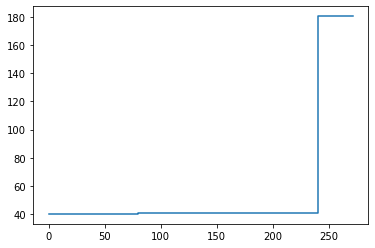

In [297]:
plot_bid_curve(df_curve, '2019-12-03', 24)

In [298]:
date_hour_info('2019-12-03', 24)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
3940,360.60,2019,12,3,24,1,40.20,80.00,2019-12-03,Tuesday,80.00
3941,360.60,2019,12,3,24,2,40.50,80.00,2019-12-03,Tuesday,160.00
3942,360.60,2019,12,3,24,3,40.80,80.00,2019-12-03,Tuesday,240.00
3943,360.60,2019,12,3,24,4,180.30,31.20,2019-12-03,Tuesday,271.20


In [299]:
df_curve.shape[0]-struct_block_24h.shape[0]

-1089

In [300]:
struct_block_24h[(struct_block_24h['Date']=='2019-12-03') & (struct_block_24h['Period']==24)]

,Date,Year,Month,Day,Period,Block
3955,2019-12-03,2019,12,3,24,1
3956,2019-12-03,2019,12,3,24,2
3957,2019-12-03,2019,12,3,24,3
3958,2019-12-03,2019,12,3,24,4
3959,2019-12-03,2019,12,3,24,5


In [301]:
df_tot_struct_24h[(df_tot_struct_24h['Date']=='2019-12-03') & (df_tot_struct_24h['Period']==23)]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
3950,360.60,2019,12,3,23,1,40.20,80.00,2019-12-03,Tuesday,80.00
3951,360.60,2019,12,3,23,2,40.50,80.00,2019-12-03,Tuesday,160.00
3952,360.60,2019,12,3,23,3,40.80,80.00,2019-12-03,Tuesday,240.00
3953,360.60,2019,12,3,23,4,180.30,31.20,2019-12-03,Tuesday,271.20
3954,360.60,2019,12,3,23,5,180.30,0.00,2019-12-03,Tuesday,271.20


In [302]:
df_tot_struct_24h.shape

(43920, 11)

In [303]:
df_curve[(df_curve['Date']=='2019-12-03') & (df_curve['Period']==23)]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
3936,360.60,2019,12,3,23,1,40.20,80.00,2019-12-03,Tuesday,80.00
3937,360.60,2019,12,3,23,2,40.50,80.00,2019-12-03,Tuesday,160.00
3938,360.60,2019,12,3,23,3,40.80,80.00,2019-12-03,Tuesday,240.00
3939,360.60,2019,12,3,23,4,180.30,31.20,2019-12-03,Tuesday,271.20


### 3.2.3. CREATING AN NEW DATAFRAME WITH PRICE AND ENERGY TIME-LAGGED

In [304]:
df_tot_lagT = df_tot_struct_24h.copy()

In [305]:
time_lag1 = 24 #One day in hours
time_lag2 = 24*7 #One week in hours
num_blocks = block_max #Number of blocks per each hour

df_tot_lagT['Energy_24h'] = df_tot_lagT['Energy'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_168h'] = df_tot_lagT['Energy'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Price_24h'] = df_tot_lagT['Price'].shift(periods=time_lag1*num_blocks)
#Just for checking purposes
df_tot_lagT['Date_24h'] = df_tot_lagT['Date'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Period_24h'] = df_tot_lagT['Period'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Block_24h'] = df_tot_lagT['Block'].shift(periods=time_lag1*num_blocks)

df_tot_lagT['Price_168h'] = df_tot_lagT['Price'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Energy_tot_24h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_tot_168h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag2*num_blocks)
#Just for checking purposes
df_tot_lagT['Date_168h'] = df_tot_lagT['Date'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Period_168h'] = df_tot_lagT['Period'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Block_168h'] = df_tot_lagT['Block'].shift(periods=time_lag2*num_blocks)

In [306]:
df_tot_lagT.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,...,Price_24h,Date_24h,Period_24h,Block_24h,Price_168h,Energy_tot_24h,Energy_tot_168h,Date_168h,Period_168h,Block_168h
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,...,nan,NaT,nan,nan,nan,nan,nan,NaT,nan,nan


In [307]:
#Checking that the shift operation has been done OK

df_tot_lagT_checking = df_tot_lagT.copy()

df_tot_lagT_checking['Date_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_24h']
df_tot_lagT_checking['Date_168h_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_168h']
df_tot_lagT_checking['Period_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_24h']
df_tot_lagT_checking['Period_168h_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_168h']
df_tot_lagT_checking['Block_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_24h']
df_tot_lagT_checking['Block_168h_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_168h']

In [308]:
df_tot_lagT_checking[['Date_OK','Date_168h_OK','Period_OK','Period_168h_OK','Block_OK','Block_168h_OK']].describe()

,Date_OK,Date_168h_OK,Period_OK,Period_168h_OK,Block_OK,Block_168h_OK
count,43800,43080,"43,800.00","43,080.00","43,800.00","43,080.00"
mean,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
std,0 days 00:00:00,0 days 00:00:00,0.00,0.00,0.00,0.00
min,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
25%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
50%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
75%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
max,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00


In [309]:
#Everthing is OK since date date time interval is 1 day and 7 days and period, and blocks are the same for all
#of the rows

In [310]:
#Picking the correct columns
columns = ['Year', 'Month', 'Day', 'Period', 'Block', 'Date', 'Weekday',
           'Energy', 'Energy_tot','Price', 'Energy_24h', 'Energy_tot_24h', 'Price_24h', 
           'Energy_168h', 'Energy_tot_168h', 'Price_168h', 'Pot_max']

In [311]:
df_tot_lagT = df_tot_lagT[columns]

In [312]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
0,2019,11,1,1,1,2019-11-01,Friday,80.00,80.00,42.00,nan,nan,nan,nan,nan,nan,360.60
1,2019,11,1,1,2,2019-11-01,Friday,80.00,160.00,45.00,nan,nan,nan,nan,nan,nan,360.60
2,2019,11,1,1,3,2019-11-01,Friday,80.00,240.00,50.00,nan,nan,nan,nan,nan,nan,360.60
3,2019,11,1,1,4,2019-11-01,Friday,80.00,320.00,55.00,nan,nan,nan,nan,nan,nan,360.60
4,2019,11,1,1,5,2019-11-01,Friday,40.60,360.60,180.30,nan,nan,nan,nan,nan,nan,360.60


In [313]:
df_tot_lagT.iloc[int(24*11.9*7):int(24*12.1*7)]

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
1999,2019,11,17,16,5,2019-11-17,Sunday,40.60,360.60,180.30,40.60,360.60,180.30,40.60,360.60,180.30,360.60
2000,2019,11,17,17,1,2019-11-17,Sunday,80.00,80.00,64.00,80.00,80.00,50.00,80.00,80.00,50.00,360.60
2001,2019,11,17,17,2,2019-11-17,Sunday,80.00,160.00,67.00,80.00,160.00,56.00,80.00,160.00,53.50,360.60
2002,2019,11,17,17,3,2019-11-17,Sunday,80.00,240.00,70.00,80.00,240.00,60.00,80.00,240.00,57.00,360.60
2003,2019,11,17,17,4,2019-11-17,Sunday,80.00,320.00,73.00,80.00,320.00,64.00,80.00,320.00,60.50,360.60
2004,2019,11,17,17,5,2019-11-17,Sunday,40.60,360.60,180.30,40.60,360.60,180.30,40.60,360.60,180.30,360.60
2005,2019,11,17,18,1,2019-11-17,Sunday,80.00,80.00,64.00,80.00,80.00,50.00,80.00,80.00,50.00,360.60
2006,2019,11,17,18,2,2019-11-17,Sunday,80.00,160.00,67.00,80.00,160.00,56.00,80.00,160.00,53.50,360.60
2007,2019,11,17,18,3,2019-11-17,Sunday,80.00,240.00,70.00,80.00,240.00,60.00,80.00,240.00,57.00,360.60
2008,2019,11,17,18,4,2019-11-17,Sunday,80.00,320.00,73.00,80.00,320.00,64.00,80.00,320.00,60.50,360.60


In [314]:
df_tot_lagT.dropna(inplace=True)

In [315]:
#Dropping all rows with NaN, since there are not enought data to build a dataframe (due to time lagging and 
#lack of data from the original dataframe

df_tot_lagT.dropna().shape

(43080, 17)

In [316]:
#Searching for NaN

if df_tot_lagT.shape[0] == df_tot_lagT.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [317]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
840,2019,11,8,1,1,2019-11-08,Friday,80.00,80.00,43.00,80.00,80.00,43.00,80.00,80.00,42.00,360.60
841,2019,11,8,1,2,2019-11-08,Friday,80.00,160.00,46.50,80.00,160.00,46.50,80.00,160.00,45.00,360.60
842,2019,11,8,1,3,2019-11-08,Friday,80.00,240.00,50.00,80.00,240.00,50.00,80.00,240.00,50.00,360.60
843,2019,11,8,1,4,2019-11-08,Friday,80.00,320.00,53.50,80.00,320.00,53.50,80.00,320.00,55.00,360.60
844,2019,11,8,1,5,2019-11-08,Friday,40.60,360.60,180.30,40.60,360.60,180.30,40.60,360.60,180.30,360.60


In [318]:
df_tot_lagT = df_tot_lagT.reset_index(drop=True)

In [319]:
df_tot_lagT

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Pot_max
0,2019,11,8,1,1,2019-11-08,Friday,80.00,80.00,43.00,80.00,80.00,43.00,80.00,80.00,42.00,360.60
1,2019,11,8,1,2,2019-11-08,Friday,80.00,160.00,46.50,80.00,160.00,46.50,80.00,160.00,45.00,360.60
2,2019,11,8,1,3,2019-11-08,Friday,80.00,240.00,50.00,80.00,240.00,50.00,80.00,240.00,50.00,360.60
3,2019,11,8,1,4,2019-11-08,Friday,80.00,320.00,53.50,80.00,320.00,53.50,80.00,320.00,55.00,360.60
4,2019,11,8,1,5,2019-11-08,Friday,40.60,360.60,180.30,40.60,360.60,180.30,40.60,360.60,180.30,360.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43075,2020,10,31,24,1,2020-10-31,Saturday,80.00,80.00,50.00,80.00,80.00,40.00,80.00,80.00,31.00,360.60
43076,2020,10,31,24,2,2020-10-31,Saturday,80.00,160.00,54.00,80.00,160.00,44.00,40.00,120.00,34.00,360.60
43077,2020,10,31,24,3,2020-10-31,Saturday,80.00,240.00,59.00,80.00,240.00,55.00,40.00,160.00,37.00,360.60
43078,2020,10,31,24,4,2020-10-31,Saturday,80.00,320.00,69.00,80.00,320.00,65.00,160.00,320.00,52.00,360.60


In [321]:
df_tot_lagT[['Period','Date']].groupby('Period').count()

,Date
Period,
1,1795
2,1795
3,1795
4,1795
5,1795
6,1795
7,1795
8,1795
9,1795


In [322]:
df_tot_lagT.shape[0]/24

1795.0

In [323]:
(df_tot_lagT['Date'].max() - df_tot_lagT['Date'].min()).days + 1

359

In [324]:
# DELETING THIS CELL????

#Checking if for all hours = 1 only block is 1 in the original dataframe


for hour in range(1,26):
    print(hour, df_curve[df_curve['Period']==hour]['Block'].value_counts())


1 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
2 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
3 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
4 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
5 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
6 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
7 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
8 3    366
2    366
1    366
4    363
5    329
Name: Block, dtype: int64
9 2    366
1    366
3    365
4    362
5    322
Name: Block, dtype: int64
10 2    366
1    366
3    365
4    362
5    322
Name: Block, dtype: int64
11 2    366
1    366
3    365
4    362
5    322
Name: Block, dtype: int64
12 2    366
1    366
3    365
4    362
5    322
Name: Block, dtype: int64
13 2    366
1    366
3    365
4    362
5    322
Name: Block, dtype: int64
14 2    366
1    366
3    365
4    362
5    322

## 3.3. CREATING DATAFRAMES AS MODELS' INPUT


### 3.3.1. BUILDING DATAFRAMES PER PERIOD (HOUR)

In this section models' input dataframes will be created, considering that the models will be built for each period (hour). 

First of all, the following features will be considered for X:

* Weekday
* Block
* Energy 24h lagged
* Energy 168h lagged
* Price 24h lagged
* Price 168h lagged

The target variables (y) will be:

* Energy
* Price



#### 3.3.1.1. ENERGY_TOT APPROACH

Note that, as FIST APPROACH, Energy will be considered as Energy_tot ("cumsum" of Energy interval for each block).
It is considered that this approach will work better than considering Energy as target instead of Energy_tot.

Dataframes will be splitted in the following way:

* TRAIN SET: data set to train the models
* VALIDATION SET: data set to validate and to select the models' hyperparamenters
* TEST SET: data set to test the models

The sppliting will be done considering the following time preriods:

* TEST SET: last month of the data set --> 2020-10-01 to 2020-10-31
* VALIDATION SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

In [325]:
df_set = df_tot_lagT[['Year','Month','Day','Period','Date','Weekday','Block',
                      'Energy_tot','Price','Energy_tot_24h','Energy_tot_168h','Price_24h','Price_168h']]

#### TEST SET

In [326]:
df_set_TEST = df_set[(df_set['Year'] == df_set['Date'].max().year)&
               (df_set['Month'] == df_set['Date'].max().month)]

In [327]:
df_set_TEST.shape

(3720, 13)

In [328]:
df_set_TEST.shape[0]/12/24 == df_set['Date'].max().day

False

In [329]:
df_set_TEST = df_set_TEST.reset_index(drop=True)
df_set_TEST

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,2020,10,1,1,2020-10-01,Thursday,1,80.00,50.00,80.00,80.00,40.00,50.00
1,2020,10,1,1,2020-10-01,Thursday,2,120.00,55.00,120.00,120.00,45.00,55.00
2,2020,10,1,1,2020-10-01,Thursday,3,160.00,60.00,160.00,160.00,50.00,60.00
3,2020,10,1,1,2020-10-01,Thursday,4,200.00,65.00,200.00,240.00,55.00,65.00
4,2020,10,1,1,2020-10-01,Thursday,5,360.60,70.00,360.60,360.60,60.00,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,2020,10,31,24,2020-10-31,Saturday,1,80.00,50.00,80.00,80.00,40.00,31.00
3716,2020,10,31,24,2020-10-31,Saturday,2,160.00,54.00,160.00,120.00,44.00,34.00
3717,2020,10,31,24,2020-10-31,Saturday,3,240.00,59.00,240.00,160.00,55.00,37.00
3718,2020,10,31,24,2020-10-31,Saturday,4,320.00,69.00,320.00,320.00,65.00,52.00


In [330]:
df_set_TEST[df_set_TEST['Period']==23]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
110,2020,10,1,23,2020-10-01,Thursday,1,80.00,50.00,80.00,80.00,40.00,45.00
111,2020,10,1,23,2020-10-01,Thursday,2,120.00,55.00,120.00,120.00,45.00,48.00
112,2020,10,1,23,2020-10-01,Thursday,3,160.00,60.00,160.00,160.00,50.00,53.00
113,2020,10,1,23,2020-10-01,Thursday,4,200.00,65.00,200.00,240.00,55.00,58.00
114,2020,10,1,23,2020-10-01,Thursday,5,360.60,70.00,360.60,360.60,60.00,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,2020,10,31,23,2020-10-31,Saturday,1,80.00,50.00,80.00,80.00,40.00,31.00
3711,2020,10,31,23,2020-10-31,Saturday,2,160.00,54.00,160.00,120.00,44.00,34.00
3712,2020,10,31,23,2020-10-31,Saturday,3,240.00,59.00,240.00,160.00,55.00,37.00
3713,2020,10,31,23,2020-10-31,Saturday,4,320.00,69.00,320.00,320.00,65.00,52.00


In [331]:
df_set_TEST[df_set_TEST['Period']==24]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
115,2020,10,1,24,2020-10-01,Thursday,1,80.00,50.00,80.00,80.00,40.00,45.00
116,2020,10,1,24,2020-10-01,Thursday,2,120.00,55.00,120.00,120.00,45.00,48.00
117,2020,10,1,24,2020-10-01,Thursday,3,160.00,60.00,160.00,160.00,50.00,53.00
118,2020,10,1,24,2020-10-01,Thursday,4,200.00,65.00,200.00,240.00,55.00,58.00
119,2020,10,1,24,2020-10-01,Thursday,5,360.60,70.00,360.60,360.60,60.00,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,2020,10,31,24,2020-10-31,Saturday,1,80.00,50.00,80.00,80.00,40.00,31.00
3716,2020,10,31,24,2020-10-31,Saturday,2,160.00,54.00,160.00,120.00,44.00,34.00
3717,2020,10,31,24,2020-10-31,Saturday,3,240.00,59.00,240.00,160.00,55.00,37.00
3718,2020,10,31,24,2020-10-31,Saturday,4,320.00,69.00,320.00,320.00,65.00,52.00


In [332]:
(df_set_TEST['Date'].min() - timedelta(days=1))

Timestamp('2020-09-30 00:00:00')

In [333]:
#Splitting the data set in 24 dataframes (one per period to use them as models' input)

df_set_TEST_period = [df_set_TEST[df_set_TEST['Period']==hour] for hour in range(1,25)]

In [334]:
df_set_TEST_period[23]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
115,2020,10,1,24,2020-10-01,Thursday,1,80.00,50.00,80.00,80.00,40.00,45.00
116,2020,10,1,24,2020-10-01,Thursday,2,120.00,55.00,120.00,120.00,45.00,48.00
117,2020,10,1,24,2020-10-01,Thursday,3,160.00,60.00,160.00,160.00,50.00,53.00
118,2020,10,1,24,2020-10-01,Thursday,4,200.00,65.00,200.00,240.00,55.00,58.00
119,2020,10,1,24,2020-10-01,Thursday,5,360.60,70.00,360.60,360.60,60.00,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,2020,10,31,24,2020-10-31,Saturday,1,80.00,50.00,80.00,80.00,40.00,31.00
3716,2020,10,31,24,2020-10-31,Saturday,2,160.00,54.00,160.00,120.00,44.00,34.00
3717,2020,10,31,24,2020-10-31,Saturday,3,240.00,59.00,240.00,160.00,55.00,37.00
3718,2020,10,31,24,2020-10-31,Saturday,4,320.00,69.00,320.00,320.00,65.00,52.00


In [335]:
df_set_TEST_period[22]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
110,2020,10,1,23,2020-10-01,Thursday,1,80.00,50.00,80.00,80.00,40.00,45.00
111,2020,10,1,23,2020-10-01,Thursday,2,120.00,55.00,120.00,120.00,45.00,48.00
112,2020,10,1,23,2020-10-01,Thursday,3,160.00,60.00,160.00,160.00,50.00,53.00
113,2020,10,1,23,2020-10-01,Thursday,4,200.00,65.00,200.00,240.00,55.00,58.00
114,2020,10,1,23,2020-10-01,Thursday,5,360.60,70.00,360.60,360.60,60.00,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,2020,10,31,23,2020-10-31,Saturday,1,80.00,50.00,80.00,80.00,40.00,31.00
3711,2020,10,31,23,2020-10-31,Saturday,2,160.00,54.00,160.00,120.00,44.00,34.00
3712,2020,10,31,23,2020-10-31,Saturday,3,240.00,59.00,240.00,160.00,55.00,37.00
3713,2020,10,31,23,2020-10-31,Saturday,4,320.00,69.00,320.00,320.00,65.00,52.00


In [336]:
df_set_TEST_period[23].shape[0]/block_max == df_set['Date'].max().day

True

In [337]:
df_X_TEST = []
y_TEST = []

for df in df_set_TEST_period:
    df_X_TEST.append(df[['Weekday','Block','Energy_tot_24h','Energy_tot_168h',
                                   'Price_24h','Price_168h']])
    y_TEST.append(np.array(df[['Energy_tot','Price']])) #Note y_val is a np.array

In [338]:
y_TEST[0]

array([[ 80. ,  50. ],
       [120. ,  55. ],
       [160. ,  60. ],
       [200. ,  65. ],
       [360.6,  70. ],
       [ 80. ,  38. ],
       [160. ,  43. ],
       [240. ,  48. ],
       [320. ,  56. ],
       [360.6,  63. ],
       [ 80. ,  16.2],
       [160. ,  21.2],
       [240. ,  26.2],
       [320. ,  41.2],
       [360.6,  48.2],
       [ 80. ,  17.2],
       [160. ,  19.2],
       [240. ,  24.2],
       [320. ,  39.2],
       [360.6,  46.2],
       [ 80. ,  17.2],
       [160. ,  19.2],
       [240. ,  24.2],
       [320. ,  39.2],
       [360.6,  46.2],
       [ 80. ,  44.4],
       [160. ,  47.4],
       [240. ,  54.4],
       [320. ,  61.4],
       [360.6,  68.4],
       [ 80. ,  44.4],
       [160. ,  47.4],
       [240. ,  54.4],
       [320. ,  61.4],
       [360.6,  68.4],
       [ 80. ,  44.4],
       [160. ,  47.4],
       [240. ,  54.4],
       [320. ,  61.4],
       [360.6,  68.4],
       [ 80. ,  40.5],
       [160. ,  41. ],
       [240. ,  46. ],
       [320

In [339]:
df_X_TEST[0]

,Weekday,Block,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,Thursday,1,80.00,80.00,40.00,50.00
1,Thursday,2,120.00,120.00,45.00,55.00
2,Thursday,3,160.00,160.00,50.00,60.00
3,Thursday,4,200.00,240.00,55.00,65.00
4,Thursday,5,360.60,360.60,60.00,180.30
...,...,...,...,...,...,...
3600,Saturday,1,80.00,80.00,50.00,25.00
3601,Saturday,2,160.00,120.00,54.00,29.00
3602,Saturday,3,240.00,160.00,59.00,32.00
3603,Saturday,4,320.00,320.00,69.00,47.00


#### VALIDATION SET

In [340]:
df_set_VAL = df_set[(df_set['Year'] == (df_set_TEST['Date'].min() - timedelta(days=1)).year)&
               (df_set['Month'] == (df_set_TEST['Date'].min() - timedelta(days=1)).month)]

In [341]:
df_set_VAL.shape[0]/12/24 == (df_set_TEST['Date'].min() - timedelta(days=1)).day

False

In [342]:
df_set_VAL = df_set_VAL.reset_index(drop=True)
df_set_VAL

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,2020,9,1,1,2020-09-01,Tuesday,1,80.00,37.00,80.00,80.00,30.00,50.00
1,2020,9,1,1,2020-09-01,Tuesday,2,160.00,41.00,160.00,160.00,58.00,53.00
2,2020,9,1,1,2020-09-01,Tuesday,3,240.00,45.00,240.00,200.00,62.00,57.00
3,2020,9,1,1,2020-09-01,Tuesday,4,269.90,53.00,320.00,240.00,65.00,60.00
4,2020,9,1,1,2020-09-01,Tuesday,5,269.90,53.00,360.60,360.60,180.30,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2020,9,30,24,2020-09-30,Wednesday,1,80.00,40.00,80.00,80.00,45.00,45.00
3596,2020,9,30,24,2020-09-30,Wednesday,2,120.00,45.00,120.00,160.00,50.00,48.00
3597,2020,9,30,24,2020-09-30,Wednesday,3,160.00,50.00,160.00,240.00,60.00,53.00
3598,2020,9,30,24,2020-09-30,Wednesday,4,200.00,55.00,200.00,320.00,65.00,58.00


In [343]:
df_set_VAL_period = [df_set_VAL[df_set_VAL['Period']==hour] for hour in range(1,25)]

In [344]:
df_set_VAL_period[23]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
115,2020,9,1,24,2020-09-01,Tuesday,1,80.00,45.00,80.00,80.00,35.00,50.00
116,2020,9,1,24,2020-09-01,Tuesday,2,160.00,49.00,160.00,160.00,58.00,53.00
117,2020,9,1,24,2020-09-01,Tuesday,3,240.00,53.00,240.00,200.00,62.00,57.00
118,2020,9,1,24,2020-09-01,Tuesday,4,269.90,61.00,269.90,240.00,65.00,60.00
119,2020,9,1,24,2020-09-01,Tuesday,5,269.90,61.00,269.90,360.60,65.00,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2020,9,30,24,2020-09-30,Wednesday,1,80.00,40.00,80.00,80.00,45.00,45.00
3596,2020,9,30,24,2020-09-30,Wednesday,2,120.00,45.00,120.00,160.00,50.00,48.00
3597,2020,9,30,24,2020-09-30,Wednesday,3,160.00,50.00,160.00,240.00,60.00,53.00
3598,2020,9,30,24,2020-09-30,Wednesday,4,200.00,55.00,200.00,320.00,65.00,58.00


In [345]:
df_set_VAL_period[23].shape[0]/block_max == (df_set_TEST['Date'].min() - timedelta(days=1)).day

True

In [346]:
df_X_VAL = []
y_VAL = []

for df in df_set_VAL_period:
    df_X_VAL.append(df[['Weekday','Block','Energy_tot_24h','Energy_tot_168h',
                                     'Price_24h','Price_168h']])
    y_VAL.append(np.array(df[['Energy_tot','Price']])) #Note y_test is a np.array

In [347]:
y_VAL[0].shape

(150, 2)

In [348]:
df_X_VAL[0]

,Weekday,Block,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,Tuesday,1,80.00,80.00,30.00,50.00
1,Tuesday,2,160.00,160.00,58.00,53.00
2,Tuesday,3,240.00,200.00,62.00,57.00
3,Tuesday,4,320.00,240.00,65.00,60.00
4,Tuesday,5,360.60,360.60,180.30,180.30
...,...,...,...,...,...,...
3480,Wednesday,1,80.00,80.00,50.00,50.00
3481,Wednesday,2,120.00,160.00,55.00,55.00
3482,Wednesday,3,160.00,240.00,60.00,60.00
3483,Wednesday,4,200.00,320.00,65.00,65.00


#### TRAIN SET

In [349]:
df_set_TRAIN_start = df_set[((df_set['Date'] == df_set['Date'].min()) & (df_set['Period'] == 1)  & (df_set['Block'] == 1))].index
df_set_TRAIN_start[0]

0

In [350]:
df_set_TRAIN_end = df_set[(df_set['Date'] == df_set_VAL['Date'].min()- timedelta(days=1)) & (df_set['Period'] == 24)  & (df_set['Block'] == block_max)].index
df_set_TRAIN_end[0]

35759

In [351]:
df_set_TRAIN = df_set.iloc[df_set_TRAIN_start[0]:df_set_TRAIN_end[0]+1]
df_set_TRAIN

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,2019,11,8,1,2019-11-08,Friday,1,80.00,43.00,80.00,80.00,43.00,42.00
1,2019,11,8,1,2019-11-08,Friday,2,160.00,46.50,160.00,160.00,46.50,45.00
2,2019,11,8,1,2019-11-08,Friday,3,240.00,50.00,240.00,240.00,50.00,50.00
3,2019,11,8,1,2019-11-08,Friday,4,320.00,53.50,320.00,320.00,53.50,55.00
4,2019,11,8,1,2019-11-08,Friday,5,360.60,180.30,360.60,360.60,180.30,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35755,2020,8,31,24,2020-08-31,Monday,1,80.00,35.00,80.00,80.00,55.00,48.00
35756,2020,8,31,24,2020-08-31,Monday,2,160.00,58.00,160.00,160.00,58.00,51.00
35757,2020,8,31,24,2020-08-31,Monday,3,240.00,62.00,240.00,200.00,62.00,55.00
35758,2020,8,31,24,2020-08-31,Monday,4,269.90,65.00,320.00,240.00,65.00,58.00


In [352]:
df_set_num_days = (df_set['Date'].max()-df_set['Date'].min()).days + 1 
df_set_TEST_num_days = (df_set_TEST['Date'].max()-df_set_TEST['Date'].min()).days + 1
df_set_VAL_num_days = (df_set_VAL['Date'].max()-df_set_VAL['Date'].min()).days + 1
df_set_TRAIN_num_days = df_set_num_days - df_set_TEST_num_days - df_set_VAL_num_days
df_set_TRAIN_num_days

298

In [353]:
df_set_VAL.shape[0]/block_max/24 == df_set_VAL_num_days

True

In [354]:
df_set_TRAIN_period = [df_set_TRAIN[df_set_TRAIN['Period']==hour] for hour in range(1,25)]

In [355]:
df_set_TRAIN_period[23]

,Year,Month,Day,Period,Date,Weekday,Block,Energy_tot,Price,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
115,2019,11,8,24,2019-11-08,Friday,1,80.00,43.00,80.00,80.00,38.00,42.00
116,2019,11,8,24,2019-11-08,Friday,2,160.00,46.50,160.00,160.00,39.00,45.00
117,2019,11,8,24,2019-11-08,Friday,3,240.00,50.00,240.00,240.00,44.00,50.00
118,2019,11,8,24,2019-11-08,Friday,4,320.00,53.50,320.00,320.00,47.50,55.00
119,2019,11,8,24,2019-11-08,Friday,5,360.60,180.30,360.60,360.60,180.30,180.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35755,2020,8,31,24,2020-08-31,Monday,1,80.00,35.00,80.00,80.00,55.00,48.00
35756,2020,8,31,24,2020-08-31,Monday,2,160.00,58.00,160.00,160.00,58.00,51.00
35757,2020,8,31,24,2020-08-31,Monday,3,240.00,62.00,240.00,200.00,62.00,55.00
35758,2020,8,31,24,2020-08-31,Monday,4,269.90,65.00,320.00,240.00,65.00,58.00


In [356]:
df_set_TRAIN_period[23].shape[0]/block_max == df_set_TRAIN_num_days

True

In [357]:
df_X_TRAIN = []
y_TRAIN = []

for df in df_set_TRAIN_period:
    df_X_TRAIN.append(df[['Weekday','Block','Energy_tot_24h','Energy_tot_168h',
                                       'Price_24h','Price_168h']])
    y_TRAIN.append(np.array(df[['Energy_tot','Price']])) #Note y_train is a np.array

In [358]:
y_TRAIN[0]

array([[ 80. ,  43. ],
       [160. ,  46.5],
       [240. ,  50. ],
       ...,
       [240. ,  62. ],
       [320. ,  65. ],
       [360.6, 180.3]])

In [359]:
df_X_TRAIN[0]

,Weekday,Block,Energy_tot_24h,Energy_tot_168h,Price_24h,Price_168h
0,Friday,1,80.00,80.00,43.00,42.00
1,Friday,2,160.00,160.00,46.50,45.00
2,Friday,3,240.00,240.00,50.00,50.00
3,Friday,4,320.00,320.00,53.50,55.00
4,Friday,5,360.60,360.60,180.30,180.30
...,...,...,...,...,...,...
35640,Monday,1,80.00,80.00,55.00,48.00
35641,Monday,2,160.00,160.00,58.00,51.00
35642,Monday,3,240.00,200.00,62.00,55.00
35643,Monday,4,320.00,240.00,65.00,58.00


#### 3.3.1.2. DELTA ENERGY APPROACH

Note that, as SECOND APPROACH, Delta Energy will be considered as Energy (Energy interval for each block).

Dataframes will be splitted in the same way as it was done with the Energy_tot approach:

* TEST SET: last month of the data set --> 2020-10-01 to 2020-10-31
* VALIDATION SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

In [360]:
df_set_dE = df_tot_lagT[['Year','Month','Day','Period','Date','Weekday','Block',
                      'Energy','Price','Energy_24h','Energy_168h','Price_24h','Price_168h']]

#### TEST SET

In [361]:
df_set_dE_TEST = df_set_dE[(df_set_dE['Year'] == df_set_dE['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE['Date'].max().month)]
df_set_dE_TEST = df_set_dE_TEST.reset_index(drop=True)
df_set_dE_TEST_period = [df_set_dE_TEST[df_set_dE_TEST['Period']==hour] for hour in range(1,25)]

df_X_dE_TEST = []
y_dE_TEST = []

for df in df_set_dE_TEST_period:
    df_X_dE_TEST.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_TEST.append(np.array(df[['Energy','Price']]))

#### VALIDATION SET

In [362]:
df_set_dE_VAL = df_set_dE[(df_set_dE['Year'] == (df_set_dE_TEST['Date'].min() - timedelta(days=1)).year)&
               (df_set_dE['Month'] == (df_set_dE_TEST['Date'].min() - timedelta(days=1)).month)]
df_set_dE_VAL = df_set_dE_VAL.reset_index(drop=True)

df_set_dE_VAL_period = [df_set_dE_VAL[df_set_dE_VAL['Period']==hour] for hour in range(1,25)]

df_X_dE_VAL = []
y_dE_VAL = []

for df in df_set_dE_VAL_period:
    df_X_dE_VAL.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_VAL.append(np.array(df[['Energy','Price']])) #Note y_test is a np.array

#### TRAIN SET

In [392]:
df_set_dE_TRAIN_start = df_set_dE[((df_set_dE['Date'] == df_set_dE['Date'].min()) 
                                   & (df_set_dE['Period'] == 1)  
                                   & (df_set_dE['Block'] == 1))].index

df_set_dE_TRAIN_end = df_set_dE[(df_set_dE['Date'] == df_set_dE_VAL['Date'].min()- timedelta(days=1)) 
                                & (df_set_dE['Period'] == 24)  & (df_set_dE['Block'] == block_max)].index

df_set_dE_TRAIN = df_set_dE.iloc[df_set_dE_TRAIN_start[0]:df_set_dE_TRAIN_end[0]+1]

df_set_dE_num_days = (df_set_dE['Date'].max()-df_set_dE['Date'].min()).days + 1 
df_set_dE_TEST_num_days = (df_set_dE_TEST['Date'].max()-df_set_dE_TEST['Date'].min()).days + 1
df_set_dE_VAL_num_days = (df_set_dE_VAL['Date'].max()-df_set_dE_VAL['Date'].min()).days + 1
df_set_dE_TRAIN_num_days = df_set_dE_num_days - df_set_dE_TEST_num_days - df_set_dE_VAL_num_days
df_set_dE_TRAIN_num_days

df_set_dE_TRAIN_period = [df_set_dE_TRAIN[df_set_dE_TRAIN['Period']==hour] for hour in range(1,25)]

df_X_dE_TRAIN = []
y_dE_TRAIN = []

for df in df_set_dE_TRAIN_period:
    df_X_dE_TRAIN.append(df[['Weekday','Block','Energy_24h','Energy_168h','Price_24h','Price_168h']])
    y_dE_TRAIN.append(np.array(df[['Energy','Price']])) #Note y_train is a np.array

### 3.3.2. NORMALIZATION AND ONE-HOT-ENCODING FOR FEATURES MODELS' INPUT

In this section X_train, X_val, and X_test will be transformed to normalize the Price and Energy features (24h and 168h lagged) and Weekday, and Block (categorical variables) will be transformed using One-Hot-Encoding.

#### 3.3.2.1. ENERGY_TOT APPROACH

#### TRAIN SET - ENCODING


In [393]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder


df_X_TRAIN_cat = []

for df in df_X_TRAIN:
    df_X_TRAIN_cat.append(df[['Weekday','Block']])


In [394]:
len(df_X_TRAIN_cat)

24

In [395]:
one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_TRAIN_cat_onehot_encoder = []

for hour in range(0,len(df_X_TRAIN)):
    
    df_X_TRAIN_cat_onehot_encoder.append(one_encoder.fit(df_X_TRAIN_cat[hour]))

In [396]:
df_X_TRAIN_cat_onehot = []

for hour in range(0,len(df_X_TRAIN)):
    
    df_X_TRAIN_cat_onehot.append(one_encoder.transform(df_X_TRAIN_cat[hour]))

In [397]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.

Energy_tot_max = df_tot_lagT['Pot_max'].max()
Energy_tot_max

360.6

In [398]:
df_X_TRAIN[0].columns

Index(['Weekday', 'Block', 'Energy_tot_24h', 'Energy_tot_168h', 'Price_24h',
       'Price_168h'],
      dtype='object')

In [399]:
df_X_TRAIN_energy_norm = []

for df in df_X_TRAIN:
    df_X_TRAIN_energy_norm.append(df[['Energy_tot_24h', 'Energy_tot_168h']]/Energy_tot_max)

In [400]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

In [401]:
df_X_TRAIN_price = []

for df in df_X_TRAIN:
    df_X_TRAIN_price.append(df[['Price_24h','Price_168h']])

In [402]:
std_encoder = StandardScaler()

df_X_TRAIN_price_std_encoder = []

for hour in range(0,len(df_X_TRAIN)):
    
    df_X_TRAIN_price_std_encoder.append(std_encoder.fit(df_X_TRAIN_price[hour]))

In [403]:
df_X_TRAIN_price_std = []

for hour in range(0,len(df_X_TRAIN)):
    
    df_X_TRAIN_price_std.append(std_encoder.transform(df_X_TRAIN_price[hour]))

In [404]:
df_X_TRAIN_cat_onehot[0].shape, df_X_TRAIN_energy_norm[0].shape, df_X_TRAIN_price_std[0].shape

((1490, 12), (1490, 2), (1490, 2))

In [405]:
len(df_X_TRAIN_cat_onehot), len(df_X_TRAIN_energy_norm), len(df_X_TRAIN_price_std)

(24, 24, 24)

In [406]:
len(df_X_TRAIN)

24

In [407]:
X_TRAIN = []

for hour in range(0,len(df_X_TRAIN)):

    X_TRAIN.append(np.concatenate((df_X_TRAIN_cat_onehot[hour], 
                             df_X_TRAIN_energy_norm[hour],
                             df_X_TRAIN_price_std[hour]),
                            axis=1))

In [408]:
len(X_TRAIN)

24

In [409]:
X_TRAIN[0].shape

(1490, 16)

In [410]:
type(X_TRAIN[0])

numpy.ndarray

#### TEST SET - ENCODING

In [411]:
#One-hot encoding will be used to convert variables from categorical to binary.

df_X_TEST_cat = []
for df in df_X_TEST:
    df_X_TEST_cat.append(df[['Weekday','Block']])
    
df_X_TEST_cat_onehot = []
for hour in range(0,len(df_X_TEST)):
    df_X_TEST_cat_onehot.append(one_encoder.transform(df_X_TEST_cat[hour]))
    
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_TEST_energy_norm = []
for df in df_X_TEST:
    df_X_TEST_energy_norm.append(df[['Energy_tot_24h', 'Energy_tot_168h']]/Energy_tot_max)
    
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)
df_X_TEST_price = []

for df in df_X_TEST:
    df_X_TEST_price.append(df[['Price_24h','Price_168h']])
    
df_X_TEST_price_std = []
for hour in range(0,len(df_X_TEST)):
    df_X_TEST_price_std.append(std_encoder.transform(df_X_TEST_price[hour]))
    
X_TEST = []
for hour in range(0,len(df_X_TEST)):
    X_TEST.append(np.concatenate((df_X_TEST_cat_onehot[hour], 
                             df_X_TEST_energy_norm[hour],
                             df_X_TEST_price_std[hour]),
                            axis=1))

#### VALIDATION SET - ENCODING

In [412]:
#One-hot encoding will be used to convert variables from categorical to binary.

df_X_VAL_cat = []
for df in df_X_VAL:
    df_X_VAL_cat.append(df[['Weekday','Block']])
    
df_X_VAL_cat_onehot = []
for hour in range(0,len(df_X_VAL)):
    df_X_VAL_cat_onehot.append(one_encoder.transform(df_X_VAL_cat[hour]))
    
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_VAL_energy_norm = []
for df in df_X_VAL:
    df_X_VAL_energy_norm.append(df[['Energy_tot_24h', 'Energy_tot_168h']]/Energy_tot_max)
    
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)
df_X_VAL_price = []

for df in df_X_VAL:
    df_X_VAL_price.append(df[['Price_24h','Price_168h']])
    
df_X_VAL_price_std = []
for hour in range(0,len(df_X_VAL)):
    df_X_VAL_price_std.append(std_encoder.transform(df_X_VAL_price[hour]))
    
X_VAL = []
for hour in range(0,len(df_X_VAL)):
    X_VAL.append(np.concatenate((df_X_VAL_cat_onehot[hour], 
                             df_X_VAL_energy_norm[hour],
                             df_X_VAL_price_std[hour]),
                            axis=1))

#### TRAIN + VALIDATION SET

In [413]:
X_TRAIN_VAL = []

for hour in range(0,len(df_X_TRAIN)):
    X_TRAIN_VAL.append(np.concatenate((X_TRAIN[hour], 
                             X_VAL[hour]),
                            axis=0))

In [414]:
X_TRAIN_VAL[23].shape, X_TRAIN[23].shape, X_VAL[23].shape

((1640, 16), (1490, 16), (150, 16))

In [415]:
y_TRAIN_VAL = []

for hour in range(0,len(df_X_TRAIN)):
    y_TRAIN_VAL.append(np.concatenate((y_TRAIN[hour], 
                             y_VAL[hour]),
                            axis=0))

In [416]:
y_TRAIN_VAL[23].shape, y_TRAIN[23].shape, y_VAL[23].shape

((1640, 2), (1490, 2), (150, 2))

#### 3.3.2.2. DELTA ENERGY APPROACH

#### TRAIN SET - ENCODING

In [417]:
df_X_dE_TRAIN_energy_norm = [df[['Energy_24h', 'Energy_168h']]/Energy_tot_max for df in df_X_dE_TRAIN]

X_dE_TRAIN = []

for hour in range(0,len(df_X_TRAIN)):

    X_dE_TRAIN.append(np.concatenate((df_X_TRAIN_cat_onehot[hour], 
                             df_X_dE_TRAIN_energy_norm[hour],
                             df_X_TRAIN_price_std[hour]),
                            axis=1))

#### TEST SET - ENCODING

In [418]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_TEST_energy_norm = []
for df in df_X_dE_TEST:
    df_X_dE_TEST_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
X_dE_TEST = []
for hour in range(0,len(df_X_dE_TEST)):
    X_dE_TEST.append(np.concatenate((df_X_TEST_cat_onehot[hour], 
                             df_X_dE_TEST_energy_norm[hour],
                             df_X_TEST_price_std[hour]),
                            axis=1))

#### VALIDATION SET - ENCODING

In [419]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_VAL_energy_norm = []
for df in df_X_dE_VAL:
    df_X_dE_VAL_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
X_dE_VAL = []
for hour in range(0,len(df_X_dE_VAL)):
    X_dE_VAL.append(np.concatenate((df_X_VAL_cat_onehot[hour], 
                             df_X_dE_VAL_energy_norm[hour],
                             df_X_VAL_price_std[hour]),
                            axis=1))

#### TRAIN + VALIDATION SET

In [420]:
X_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    X_dE_TRAIN_VAL.append(np.concatenate((X_dE_TRAIN[hour], 
                             X_dE_VAL[hour]),
                            axis=0))

In [421]:
y_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    y_dE_TRAIN_VAL.append(np.concatenate((y_dE_TRAIN[hour], 
                             y_dE_VAL[hour]),
                            axis=0))

In [422]:
y_dE_TRAIN_VAL[23].shape, y_dE_TRAIN[23].shape, y_dE_VAL[23].shape

((1640, 2), (1490, 2), (150, 2))

In [423]:
y_dE_TRAIN_VAL[23]

array([[ 80. ,  43. ],
       [ 80. ,  46.5],
       [ 80. ,  50. ],
       ...,
       [ 40. ,  50. ],
       [ 40. ,  55. ],
       [160.6,  60. ]])

## 4. MULTI-OUTPUT REGRESSION MODELS

In this section, several multi-output regression models will be develop to predict Energy_tot and Price.

Test set will be used to adjust the models' hyperparameters and Validation test will be used to calibrate the quality of the models.

In [424]:
type(X_TRAIN[0]), type(y_TRAIN[0])

(numpy.ndarray, numpy.ndarray)

In [425]:
y_TRAIN[0]

array([[ 80. ,  43. ],
       [160. ,  46.5],
       [240. ,  50. ],
       ...,
       [240. ,  62. ],
       [320. ,  65. ],
       [360.6, 180.3]])

### 4.1. MULTI-OUTPUT RANDOM FOREST REGRESSION

Models are fitted with the TEST SET and predictions to fit the hyperparameters are checked with VALIDATION SET.

#### 4.1.1. ENERGY_TOT APPROACH

In [426]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

hours = len(X_TRAIN)

y_VAL_pred_rf = []

for hour in range(0,hours):
    y_VAL_pred_rf.append(reg_rf.fit(X_TRAIN[hour],y_TRAIN[hour]).predict(X_VAL[hour]))

In [427]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_VAL_rf = []
for hour in range(0,hours):
    mae_VAL_rf.append(mean_absolute_error(y_VAL[hour],y_VAL_pred_rf[hour]))
mae_VAL_rf

[16.155273982247767,
 16.599361881171156,
 15.034566771727574,
 15.115920064880621,
 15.04818376323048,
 15.631715441324214,
 15.94886163886871,
 16.143278557562198,
 15.87756958146719,
 15.505431401782602,
 17.23871220107618,
 17.020672735224387,
 16.23033253945473,
 15.96760104675408,
 16.049541321960778,
 16.375899082224066,
 16.30465328216214,
 16.793731311238936,
 17.624019612467933,
 17.53393812359895,
 17.344137091160103,
 17.189543906595695,
 16.93892167719829,
 18.21382403732826]

In [428]:
max(mae_VAL_rf)

18.21382403732826

In [429]:
# RMSE from random forest

rmse_VAL_rf = []
for hour in range(0,hours):
    rmse_VAL_rf.append(np.sqrt(mean_squared_error(y_VAL[hour],y_VAL_pred_rf[hour])))
rmse_VAL_rf

[28.577438198607247,
 29.769756852464788,
 28.341267640423894,
 28.873170591440108,
 28.824710986822982,
 29.13534683631559,
 28.74514898435909,
 28.690088730755047,
 26.294277288735934,
 26.086217637547566,
 28.261358353600595,
 27.99444153926235,
 27.196049585767504,
 26.784330300134187,
 26.976068677318036,
 27.511131789706,
 27.295485843492788,
 27.86996799684259,
 30.667880386717712,
 29.422083537010188,
 28.510613026865638,
 28.222869596502708,
 27.97116802952871,
 30.085906391728468]

In [430]:
max(rmse_VAL_rf)

30.667880386717712

In [431]:
np.mean(mae_VAL_rf) , np.mean(rmse_VAL_rf)

(16.411903793862795, 28.254449116747907)

In [432]:
# JUST CHECKING WITH TEST SET (without any optimization in TEST SET) ---> PRELIMINARY 
# TO BE REVISED

hours = len(X_TEST)

y_TEST_pred_rf = []
for hour in range(0,hours):
    y_TEST_pred_rf.append(reg_rf.fit(X_TRAIN_VAL[hour],y_TRAIN_VAL[hour]).predict(X_TEST[hour]))

In [433]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_TEST_rf = []
for hour in range(0,hours):
    mae_TEST_rf.append(mean_absolute_error(y_TEST[hour],y_TEST_pred_rf[hour]))
mae_TEST_rf

[7.557916086465432,
 7.398989227914118,
 7.656382652191099,
 7.401147068806662,
 7.5618975852349966,
 7.403664056367555,
 7.471789967593441,
 7.8904313292979875,
 7.3835323955203345,
 7.490158528520122,
 7.681088456285332,
 7.8257389997817395,
 8.20955257698169,
 8.729543285543082,
 8.429513845094416,
 8.526721018106501,
 8.034497905512463,
 8.07015648431201,
 8.050675324962995,
 8.07436001227127,
 7.966324237685971,
 8.060483383503321,
 7.982158708604122,
 7.932245952078627]

In [434]:
# RMSE from random forest

rmse_TEST_rf = []
for hour in range(0,hours):
    rmse_TEST_rf.append(np.sqrt(mean_squared_error(y_TEST[hour],y_TEST_pred_rf[hour])))
rmse_TEST_rf

[15.907089520963558,
 16.247026308984534,
 16.722022372392352,
 16.802319432148963,
 17.109301670501186,
 16.81117922432374,
 16.340256064836797,
 17.387874640407272,
 16.137115134901862,
 16.440468856144165,
 16.809106292786076,
 17.066582773564736,
 17.48562598141743,
 17.621817139606343,
 18.569399791983397,
 18.539624843641587,
 17.701871598283816,
 17.8647205216575,
 17.009042227213115,
 17.3750858089266,
 16.986257434140185,
 17.52345621517448,
 16.87727320551612,
 16.847365871355372]

In [435]:
max(mae_TEST_rf)

8.729543285543082

In [436]:
np.mean(mae_TEST_rf), np.mean(rmse_TEST_rf)

(7.866207045359803, 17.0909117887863)

In [437]:
np.mean(mae_TEST_rf), np.mean(mae_VAL_rf)

(7.866207045359803, 16.411903793862795)

In [438]:
np.mean(rmse_TEST_rf), np.mean(rmse_VAL_rf)

(17.0909117887863, 28.254449116747907)

#### 4.1.2. DELTA ENERGY APPROACH

In [439]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

hours = len(X_dE_TRAIN)

y_dE_VAL_pred_rf = []

for hour in range(0,hours):
    y_dE_VAL_pred_rf.append(reg_rf.fit(X_dE_TRAIN[hour],y_dE_TRAIN[hour]).predict(X_dE_VAL[hour]))

In [440]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_dE_VAL_rf = []
for hour in range(0,hours):
    mae_dE_VAL_rf.append(mean_absolute_error(y_dE_VAL[hour],y_dE_VAL_pred_rf[hour]))
mae_dE_VAL_rf

[12.128085432444776,
 12.322891947367546,
 11.416325011773795,
 11.249454004908934,
 11.468721343084422,
 11.063033533801434,
 11.771151780186479,
 13.146563427699913,
 13.308575918192926,
 13.363280765380594,
 13.177467662118929,
 13.415843809079808,
 12.60301169426091,
 13.14024499071299,
 12.494331893472543,
 13.221369053240878,
 13.397532548562548,
 13.292328419719173,
 11.857713326815261,
 11.627107758372466,
 11.994220842897851,
 11.853559082806091,
 11.72336838046944,
 11.860599312408734]

In [441]:
max(mae_dE_VAL_rf)

13.415843809079808

In [442]:
# RMSE from random forest

rmse_dE_VAL_rf = []
for hour in range(0,hours):
    rmse_dE_VAL_rf.append(np.sqrt(mean_squared_error(y_dE_VAL[hour],y_dE_VAL_pred_rf[hour])))
rmse_dE_VAL_rf

[22.6768166944011,
 22.904409503388045,
 22.622830855805052,
 22.45983044292391,
 22.53921138423542,
 22.20455033868786,
 22.470011873409284,
 23.390327990536576,
 25.031701604970465,
 24.544004851849635,
 24.471713458767752,
 24.653039002999897,
 23.67830765906245,
 24.345351647800577,
 23.645083932815712,
 24.35165895588186,
 24.638189616267685,
 24.75646044133598,
 22.508235759645473,
 22.953854971669788,
 22.72825962950801,
 22.900399188349862,
 22.40922553330776,
 22.23167323111726]

In [443]:
max(rmse_dE_VAL_rf)

25.031701604970465

In [444]:
np.mean(mae_dE_VAL_rf) , np.mean(rmse_dE_VAL_rf)

(12.37069924749077, 23.379797857030727)

In [445]:
# JUST CHECKING WITH TEST SET (without any optimization in TEST SET) ---> PRELIMINARY 
# TO BE REVISED

hours = len(X_TEST)

y_dE_TEST_pred_rf = []
for hour in range(0,hours):
    y_dE_TEST_pred_rf.append(reg_rf.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]).predict(X_dE_TEST[hour]))

In [446]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae_dE_TEST_rf = []
for hour in range(0,hours):
    mae_dE_TEST_rf.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_rf[hour]))
mae_dE_TEST_rf

[7.531010323333776,
 7.050860621237324,
 6.978256875468009,
 6.816728123595947,
 6.908612738990817,
 6.879789110778605,
 7.4576551820924575,
 7.671703671890205,
 7.492252088541097,
 7.541660642790379,
 7.561130616306499,
 8.000550733418713,
 8.029922277232329,
 8.159323695585346,
 7.561164084696784,
 7.773461069617346,
 7.861409926600045,
 7.771278281269376,
 8.504452673767009,
 8.27515205044051,
 8.126704855959073,
 8.195503863365847,
 8.135447299166936,
 7.991968609162232]

In [447]:
# RMSE from random forest

rmse_dE_TEST_rf = []
for hour in range(0,hours):
    rmse_dE_TEST_rf.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_rf[hour])))
rmse_dE_TEST_rf

[15.673735016221961,
 15.395336137382055,
 15.781092056678773,
 15.593747346787692,
 15.966093399101332,
 16.205597345506686,
 15.998008296292557,
 15.924165038380272,
 15.966533909401154,
 16.158331917284936,
 16.113865704833263,
 17.01495150010071,
 16.79005741892953,
 16.766059977972855,
 16.866676135363775,
 16.912765475731536,
 16.984370536380034,
 16.736290836042933,
 17.64178852418234,
 16.988667569350767,
 16.3960328635609,
 16.913272519680767,
 16.155864668729524,
 16.671336587893432]

In [448]:
np.mean(mae_dE_TEST_rf), np.mean(rmse_dE_TEST_rf)

(7.678166642304444, 16.400610032574573)

In [449]:
np.mean(mae_dE_TEST_rf), np.mean(mae_dE_VAL_rf)

(7.678166642304444, 12.37069924749077)

In [450]:
np.mean(rmse_dE_TEST_rf), np.mean(rmse_dE_VAL_rf)

(16.400610032574573, 23.379797857030727)

##### SELECTING HYPERPARAMENTERS - RANDOM FOREST

In [451]:
#Creating a fixed split for GridSearch
#Since the length of all 24 sets are equal, only is necesary to create one "test_fold"

TRAIN_len = len(X_dE_TRAIN[0])
VAL_len = len(X_dE_VAL[0])

test_fold = np.repeat([-1,0], [TRAIN_len, VAL_len])

In [452]:
from sklearn.model_selection import PredefinedSplit

ps = PredefinedSplit(test_fold)

In [453]:
#Checking the number of splits
ps.get_n_splits()

1

In [ ]:
from sklearn.model_selection import GridSearchCV

reg_rf_grid = GridSearchCV(RandomForestRegressor(n_estimators=100),
                  param_grid={"max_depth":np.arange(2,11),
                              "min_samples_leaf":np.arange(10,100,15)},
                  scoring="neg_mean_absolute_error",
                  cv=ps)

In [ ]:
hours = len(X_dE_TRAIN)

y_dE_TEST_pred_rf_grid = []

for hour in range(0,hours):
    y_dE_TEST_pred_rf_grid.append(reg_rf_grid.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]).predict(X_dE_TEST[hour]))

In [ ]:
# MAE - RANDOM FOREST - GRID
mae_dE_TEST_rf_grid = []
for hour in range(0,hours):
    mae_dE_TEST_rf_grid.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour]))
mae_dE_TEST_rf_grid

In [ ]:
# RMSE from random forest

rmse_dE_TEST_rf_grid = []
for hour in range(0,hours):
    rmse_dE_TEST_rf_grid.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour])))
rmse_dE_TEST_rf_grid

In [ ]:
np.mean(mae_dE_TEST_rf_grid) , np.mean(rmse_dE_TEST_rf_grid)

In [ ]:
np.mean(mae_dE_TEST_rf) , np.mean(rmse_dE_TEST_rf)

### 4.2. MULTI-OUTPUT XG-BOOST REGRESSION

Models are fitted with the TEST SET and predictions to fit the hyperparameters are checked with VALIDATION SET.

#### 4.2.1. DELTA ENERGY APPROACH

In [ ]:
#XG-BOOST

from xgboost import XGBRegressor
#from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#reg_XGB = GradientBoostingRegressor(max_depth=4, n_estimators=100,learning_rate=0.1)

reg_XGB = XGBRegressor(max_depth=4, n_estimators=100,learning_rate=0.1)

##### DIRECT WRAPPER

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

wrapper_XGB = MultiOutputRegressor(reg_XGB)

In [ ]:
hours = len(X_dE_TRAIN)

y_dE_TEST_pred_XGB = []

for hour in range(0,hours):
    y_dE_TEST_pred_XGB.append(wrapper_XGB.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]).predict(X_dE_TEST[hour]))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE - XGBOOST - TEST
mae_dE_TEST_XGB = []
for hour in range(0,hours):
    mae_dE_TEST_XGB.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_XGB[hour]))
mae_dE_TEST_XGB

In [ ]:
# RMSE - XGBOOST - TEST

rmse_dE_TEST_XGB = []
for hour in range(0,hours):
    rmse_dE_TEST_XGB.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_XGB[hour])))
rmse_dE_TEST_XGB

In [ ]:
np.mean(mae_dE_TEST_XGB), np.mean(rmse_dE_TEST_XGB)

##### CHAIN WRAPPER

In [ ]:
from sklearn.multioutput import RegressorChain

wrapper_chain_XGB = RegressorChain(reg_XGB, order=[0,1])

In [ ]:
hours = len(X_dE_TRAIN)

y_dE_TEST_pred_chain_XGB = []

for hour in range(0,hours):
    y_dE_TEST_pred_chain_XGB.append(wrapper_chain_XGB.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]).predict(X_dE_TEST[hour]))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE - XGBOOST_chain - TEST
mae_dE_TEST_chain_XGB = []
for hour in range(0,hours):
    mae_dE_TEST_chain_XGB.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB[hour]))
mae_dE_TEST_chain_XGB

In [ ]:
# RMSE - XGBOOST_chain - TEST

rmse_dE_TEST_chain_XGB = []
for hour in range(0,hours):
    rmse_dE_TEST_chain_XGB.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB[hour])))
rmse_dE_TEST_chain_XGB

In [ ]:
np.mean(mae_dE_TEST_chain_XGB), np.mean(rmse_dE_TEST_chain_XGB)

In [ ]:
# Direct wrapper and Chain wrapper seems to be very similar

#### SELECTING XGBOOST HYPERPARAMETERS FOR CHAIN MULTI-OUTPUT WRAPPER

In [ ]:
# X tiene que ser X_TEST + X_VAL y el split según X_TEST / X_VAL

In [ ]:
from sklearn.model_selection import GridSearchCV

#We are using the same Predefined Split as for Random Forest

reg_XGB_grid = GridSearchCV(XGBRegressor(n_estimators=100),
                  param_grid={"max_depth":np.arange(2,10),
                             "learning_rate":np.arange(1,10)/10},
                  scoring="neg_mean_absolute_error",
                  cv=ps)

In [ ]:
wrapper_chain_XGB_grid = RegressorChain(reg_XGB_grid, order=[0,1])

In [ ]:
hours = len(X_dE_TRAIN)

y_dE_TEST_pred_chain_XGB_grid = []

for hour in range(0,hours):
    y_dE_TEST_pred_chain_XGB_grid.append(wrapper_chain_XGB_grid.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]).predict(X_dE_TEST[hour]))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE - XGBOOST_chain - TEST
mae_dE_TEST_chain_XGB_grid = []
for hour in range(0,hours):
    mae_dE_TEST_chain_XGB_grid.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB_grid[hour]))
mae_dE_TEST_chain_XGB_grid

In [ ]:
# RMSE - XGBOOST_chain - TEST

rmse_dE_TEST_chain_XGB_grid = []
for hour in range(0,hours):
    rmse_dE_TEST_chain_XGB_grid.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB_grid[hour])))
rmse_dE_TEST_chain_XGB_grid

In [ ]:
np.mean(mae_dE_TEST_chain_XGB_grid), np.mean(rmse_dE_TEST_chain_XGB_grid)

### 5. NEW METRIC CALCULATION: PERIOD CURVE AREA ERROR

In this section a curve area calculation per each period will be calculated in order to compare the original curve and the predicted one.

Area curve will have money (€) units and it will give good information about the model precision.

Four different cuve areas will be calculated:

+ Total curve area: A_tot
+ Area when Price is maximum: A_max
+ Area when Price is minimum: A_min
+ Celtral Area: A_cen = A_tot - A_max - A_min

#### NOTE: Calculating extreme areas when blocks are less than 2 is not possible, so it is checked only when using a complete dataframe (all blocks for all periods).

Extreme areas (when Price is maximum or minimum) can introduce a lot of error in the metric that cound be not very relevant for the objective of the project: since it is not very probably that extreme cases are chosen, the real effective zone for the purpose of the project is to predict well the central part of the curve.

#### TOTAL CURVE AREA METRIC

Different metrics based on curve area can be defined:

* Difference of the total curve area between y_dE and y_dE_pred (absolute and relative)
* Total absolute difference between y_dE and y_dE_pred (absolute and relative)

In [ ]:
#DIFFERENCE OF THE TOTAL CURVE AREAS & TOTAL ABSOLUTE DIFFERENCE OF y_dE and y_dE_pred

y_TEST_area_tot = []
y_area_tot_diff_TEST_abs = []
y_area_tot_diff_TEST_rel = []

y_TEST_area = []
y_area_diff_TEST_abs = []
y_area_diff_TEST_rel = []

for hour in range(0, hours):

    y_dE_TEST_area = (y_dE_TEST[hour][:,0]*y_dE_TEST[hour][:,1])
    y_dE_TEST_pred_rf_area = (y_dE_TEST_pred_rf[hour][:,0]*y_dE_TEST_pred_rf[hour][:,1])
    area_diff_TEST_abs = abs(y_dE_TEST_area - y_dE_TEST_pred_rf_area).sum() #Total Absolute Area Differences
    
    y_dE_TEST_area_tot = y_dE_TEST_area.sum() #Total area for the whole set period, for each hour 
    y_dE_TEST_pred_rf_area_tot = y_dE_TEST_pred_rf_area.sum()
    area_tot_diff_TEST_abs = (y_dE_TEST_area_tot - y_dE_TEST_pred_rf_area_tot) #Total Differences of Total Areas
    
    #Relative area difference
    area_diff_TEST_rel = (area_diff_TEST_abs / y_dE_TEST_area_tot) * 100
    area_tot_diff_TEST_rel = (area_tot_diff_TEST_abs / y_dE_TEST_area_tot) * 100
    
    y_area_diff_TEST_abs.append(area_diff_TEST_abs)
    y_area_diff_TEST_rel.append(area_diff_TEST_rel)
    
    y_TEST_area_tot.append(y_dE_TEST_area_tot)
    y_area_tot_diff_TEST_abs.append(area_tot_diff_TEST_abs)
    y_area_tot_diff_TEST_rel.append(area_tot_diff_TEST_rel)

In [ ]:
min(y_area_tot_diff_TEST_abs), max(y_area_tot_diff_TEST_abs), min(y_area_diff_TEST_abs), max(y_area_diff_TEST_abs)

In [ ]:
np.mean(y_area_tot_diff_TEST_abs), np.mean(y_area_diff_TEST_abs)

In [ ]:
min(y_area_tot_diff_TEST_rel), max(y_area_tot_diff_TEST_rel), min(y_area_diff_TEST_rel), max(y_area_diff_TEST_rel)

In [ ]:
np.mean(y_area_tot_diff_TEST_rel), np.mean(y_area_diff_TEST_rel)

In [ ]:
df_y_dE_TEST_area_summary = pd.DataFrame({'Area_tot(€)': y_TEST_area_tot,
              'Area_diff_abs(€)': y_area_diff_TEST_abs, 
              'Area_diff_rel(%)': y_area_diff_TEST_rel,
              'Area_tot_diff_abs(€)': y_area_tot_diff_TEST_abs, 
              'Area_tot_diff_rel(%)': y_area_tot_diff_TEST_rel})
df_y_dE_TEST_area_summary

In [ ]:
# It can be seen that the bidding area for hours from 10 to 24 is the same, so the bid is the same 
# for 15 hours per day --> Possibility of reducing models???

In [ ]:
#List of df with the comparison of real data and prediction for every hour

y_TEST_pred_summary = []

for hour in range(0,hours):

    y_TEST_pred = pd.DataFrame(np.concatenate([y_dE_TEST[hour],y_dE_TEST_pred_rf[hour]],axis=1), 
                                   columns= ['dE','Price','dE_pred','Price_pred'])
    y_TEST_pred['dE_diff'] = y_TEST_pred['dE'] - y_TEST_pred['dE_pred']
    y_TEST_pred['Price_diff'] = y_TEST_pred['Price'] - y_TEST_pred['Price_pred']
    y_TEST_pred['Area'] = y_TEST_pred['dE'] * y_TEST_pred['Price']
    y_TEST_pred['Area_pred'] = y_TEST_pred['dE_pred'] * y_TEST_pred['Price_pred']
    y_TEST_pred['Area_diff'] = y_TEST_pred['Area'] - y_TEST_pred['Area_pred']
    y_TEST_pred['Area_diff_rel(%)'] = y_TEST_pred['Area_diff']/y_TEST_pred['Area']*100
    y_TEST_pred['Period'] = hour + 1
    y_TEST_pred_summary.append(y_TEST_pred)

In [ ]:
y_TEST_pred_summary[0]

In [ ]:
y_TEST_pred_summary[9][y_TEST_pred_summary[9]['dE_diff']<-2]

In [ ]:
# Creating a df with all the comparisons (to be able to retreive info easily)

df_y_TEST_pred_summary = pd.DataFrame()

for hour in range(0, len(y_TEST_pred_summary)):
    df_y_TEST_pred_summary = pd.concat([df_y_TEST_pred_summary,y_TEST_pred_summary[hour]])
    

In [ ]:
df_y_TEST_pred_summary.fillna(0,inplace=True)
df_y_TEST_pred_summary.reset_index(drop=True,inplace=True)
df_y_TEST_pred_summary

In [ ]:
df_y_TEST_pred_summary.describe()

In [ ]:
df_y_TEST_pred_summary['Area_diff'].mean()

In [ ]:
Area_pred_mean_error_TEST = df_y_TEST_pred_summary['Area_diff'].mean()
Area_pred_mean_error_TEST_rel = df_y_TEST_pred_summary['Area_diff'].mean() / df_y_TEST_pred_summary['Area'].mean() * 100
Area_pred_mean_error_TEST, Area_pred_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred

mae_area_pred_TEST = mean_absolute_error(df_y_TEST_pred_summary['Area'],df_y_TEST_pred_summary['Area_pred'])
mae_area_pred_TEST

In [ ]:
#RMSE for Area and Area_pred

rmse_area_pred_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_summary['Area'],df_y_TEST_pred_summary['Area_pred'])))
rmse_area_pred_TEST

In [ ]:
#Looking for min and max values in the df

df_y_TEST_pred_summary[(df_y_TEST_pred_summary['Price_diff'] < -7) |
                      (df_y_TEST_pred_summary['Price_diff'] > 5)]

In [ ]:
df_y_TEST_pred_summary[(df_y_TEST_pred_summary['Price_diff'] < -7) |
                      (df_y_TEST_pred_summary['Price_diff'] > 5)]

In [ ]:
#Looking for maximum price difference
#It does not seems very important, since the error comes in a place where unit will not be operating

df_y_TEST_pred_summary [df_y_TEST_pred_summary['Area_diff_rel(%)']== float('-inf')]

In [ ]:
#Looking for minimmum price difference

df_y_TEST_pred_summary[(df_y_TEST_pred_summary['Period'] == 11) &
                      (abs(df_y_TEST_pred_summary['Price_diff']) >= 1)]

#### CURVE AREA METRIC WHEN MAXIMUM PRICE IS NOT CONSIDERED

When Price is the maximum (180.3€) the unit is not going to be operated, son these areas should not be cosidered to evaluate the quality of the model.

In [ ]:
#Looking for maximum price

df_y_TEST_pred_summary_Pmax = df_y_TEST_pred_summary[df_y_TEST_pred_summary['Price'] == df_y_TEST_pred_summary['Price'].max()]

In [ ]:
df_y_TEST_pred_summary_Pmax

In [ ]:
#df without Pmax Areas

df_y_TEST_pred_summary_noPmax = df_y_TEST_pred_summary[df_y_TEST_pred_summary['Price'] != df_y_TEST_pred_summary['Price'].max()]
df_y_TEST_pred_summary_noPmax

In [ ]:
df_y_TEST_pred_summary_noPmax.describe()

In [ ]:
df_y_TEST_pred_summary_noPmax['Area_diff'].mean()

In [ ]:
Area_pred_notPmax_mean_error_TEST = df_y_TEST_pred_summary_notPmax['Area_diff'].mean()
Area_pred_notPmax_mean_error_TEST_rel = df_y_TEST_pred_summary_notPmax['Area_diff'].mean() / df_y_TEST_pred_summary_notPmax['Area'].mean() * 100
Area_pred_notPmax_mean_error_TEST, Area_pred_notPmax_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_TEST = mean_absolute_error(df_y_TEST_pred_summary_noPmax['Area'],df_y_TEST_pred_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_TEST

In [ ]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_summary_noPmax['Area'],df_y_TEST_pred_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_TEST

####  CURVE AREA METRIC WHEN MINIMUM PRICE IS NOT CONSIDERED ---> NOT SURE IF THIS IS USEFUL

There are a lot of Areas when Price is the minimum (1.13€). Most of these areas were created when including full blocks.

In [ ]:
#Looking for minimmum price

df_y_TEST_pred_summary_Pmin = df_y_TEST_pred_summary[df_y_TEST_pred_summary['Price'] == df_y_TEST_pred_summary['Price'].min()]

In [ ]:
df_y_TEST_pred_summary_Pmin

In [ ]:
#df without Pmin Areas

df_y_TEST_pred_summary_noPmin = df_y_TEST_pred_summary[df_y_TEST_pred_summary['Price'] != df_y_TEST_pred_summary['Price'].min()]
df_y_TEST_pred_summary_noPmin

In [ ]:
df_y_TEST_pred_summary_noPmin.describe()

In [ ]:
df_y_TEST_pred_summary_noPmin['Area_diff'].mean()

In [ ]:
Area_pred_noPmin_mean_error_TEST = df_y_TEST_pred_summary_noPmin['Area_diff'].mean()
Area_pred_noPmin_mean_error_TEST_rel = df_y_TEST_pred_summary_noPmin['Area_diff'].mean() / df_y_TEST_pred_summary_noPmin['Area'].mean() * 100
Area_pred_noPmin_mean_error_TEST, Area_pred_noPmin_mean_error_TEST_rel

#### CURVE AREA METRIC WHEN MAXIMUM & MINIMUM PRICE ARE NOT CONSIDERED

In [ ]:
#df without Pmax Areas

df_y_TEST_pred_summary_noPmaxPmin = df_y_TEST_pred_summary[(df_y_TEST_pred_summary['Price'] != 
                                                            df_y_TEST_pred_summary['Price'].max()) & 
                                                           (df_y_TEST_pred_summary['Price'] != 
                                                            df_y_TEST_pred_summary['Price'].min())]
df_y_TEST_pred_summary_noPmaxPmin

In [ ]:
df_y_TEST_pred_summary_noPmaxPmin.describe()

In [ ]:
df_y_TEST_pred_summary_noPmaxPmin['Area_diff'].mean()

In [ ]:
Area_pred_noPmaxPmin_mean_error_TEST = df_y_TEST_pred_summary_noPmaxPmin['Area_diff'].mean()
Area_pred_noPmaxPmin_mean_error_TEST_rel = df_y_TEST_pred_summary_noPmaxPmin['Area_diff'].mean() / df_y_TEST_pred_summary_noPmaxPmin['Area'].mean() * 100
Area_pred_noPmaxPmin_mean_error_TEST, Area_pred_noPmaxPmin_mean_error_TEST_rel

### RANDOM FOREST AREA METRIC EVALUATION - HYPERPARAMENTERS

In [ ]:
#List of df with the comparison of real data and prediction for every hour

y_TEST_pred_grid_summary = []

for hour in range(0,hours):

    y_TEST_pred_grid = pd.DataFrame(np.concatenate([y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour]],axis=1), 
                                   columns= ['dE','Price','dE_pred','Price_pred'])
    y_TEST_pred_grid['dE_diff'] = y_TEST_pred_grid['dE'] - y_TEST_pred_grid['dE_pred']
    y_TEST_pred_grid['Price_diff'] = y_TEST_pred_grid['Price'] - y_TEST_pred_grid['Price_pred']
    y_TEST_pred_grid['Area'] = y_TEST_pred_grid['dE'] * y_TEST_pred_grid['Price']
    y_TEST_pred_grid['Area_pred'] = y_TEST_pred_grid['dE_pred'] * y_TEST_pred_grid['Price_pred']
    y_TEST_pred_grid['Area_diff'] = y_TEST_pred_grid['Area'] - y_TEST_pred_grid['Area_pred']
    y_TEST_pred_grid['Area_diff_rel(%)'] = y_TEST_pred_grid['Area_diff']/y_TEST_pred_grid['Area']*100
    y_TEST_pred_grid['Period'] = hour + 1
    y_TEST_pred_grid_summary.append(y_TEST_pred_grid)

In [ ]:
# Creating a df with all the comparisons (to be able to retreive info easily)

df_y_TEST_pred_grid_summary = pd.DataFrame()

for hour in range(0, len(y_TEST_pred_summary)):
    df_y_TEST_pred_grid_summary = pd.concat([df_y_TEST_pred_grid_summary,y_TEST_pred_grid_summary[hour]])
    

In [ ]:
df_y_TEST_pred_grid_summary.fillna(0,inplace=True)
df_y_TEST_pred_grid_summary.reset_index(drop=True,inplace=True)

In [ ]:
Area_pred_grid_mean_error_TEST = df_y_TEST_pred_grid_summary['Area_diff'].mean()
Area_pred_grid_mean_error_TEST_rel = df_y_TEST_pred_grid_summary['Area_diff'].mean() / df_y_TEST_pred_grid_summary['Area'].mean() * 100
Area_pred_grid_mean_error_TEST, Area_pred_grid_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred

mae_area_pred_grid_TEST = mean_absolute_error(df_y_TEST_pred_grid_summary['Area'],df_y_TEST_pred_grid_summary['Area_pred'])
mae_area_pred_grid_TEST

In [ ]:
#RMSE for Area and Area_pred

rmse_area_pred_grid_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_grid_summary['Area'],df_y_TEST_pred_grid_summary['Area_pred'])))
rmse_area_pred_grid_TEST

#### METRICS FOR RANDOM FOREST WITHOUT PRICE MAX PREDICTIONS

In [ ]:
#df without Pmax Areas

df_y_TEST_pred_grid_summary_noPmax = df_y_TEST_pred_grid_summary[df_y_TEST_pred_grid_summary['Price'] != df_y_TEST_pred_grid_summary['Price'].max()]

In [ ]:
df_y_TEST_pred_grid_summary_noPmax['Area_diff'].mean()

In [ ]:
Area_pred_grid_noPmax_mean_error_TEST = df_y_TEST_pred_grid_summary_noPmax['Area_diff'].mean()
Area_pred_grid_noPmax_mean_error_TEST_rel = df_y_TEST_pred_grid_summary_noPmax['Area_diff'].mean() / df_y_TEST_pred_grid_summary_noPmax['Area'].mean() * 100
Area_pred_grid_noPmax_mean_error_TEST, Area_pred_grid_noPmax_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_grid_TEST = mean_absolute_error(df_y_TEST_pred_grid_summary_noPmax['Area'],df_y_TEST_pred_grid_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_grid_TEST

In [ ]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_grid_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_grid_summary_noPmax['Area'],df_y_TEST_pred_grid_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_grid_TEST

### XGBOOST AREA METRIC EVALUATION

In [ ]:
#List of df with the comparison of real data and prediction for every hour

y_TEST_pred_XGB_summary = []

for hour in range(0,hours):

    y_TEST_pred_XGB = pd.DataFrame(np.concatenate([y_dE_TEST[hour],y_dE_TEST_pred_XGB[hour]],axis=1), 
                                   columns= ['dE','Price','dE_pred','Price_pred'])
    y_TEST_pred_XGB['dE_diff'] = y_TEST_pred_XGB['dE'] - y_TEST_pred_XGB['dE_pred']
    y_TEST_pred_XGB['Price_diff'] = y_TEST_pred_XGB['Price'] - y_TEST_pred_XGB['Price_pred']
    y_TEST_pred_XGB['Area'] = y_TEST_pred_XGB['dE'] * y_TEST_pred_XGB['Price']
    y_TEST_pred_XGB['Area_pred'] = y_TEST_pred_XGB['dE_pred'] * y_TEST_pred_XGB['Price_pred']
    y_TEST_pred_XGB['Area_diff'] = y_TEST_pred_XGB['Area'] - y_TEST_pred_XGB['Area_pred']
    y_TEST_pred_XGB['Area_diff_rel(%)'] = y_TEST_pred_XGB['Area_diff']/y_TEST_pred_XGB['Area']*100
    y_TEST_pred_XGB['Period'] = hour + 1
    y_TEST_pred_XGB_summary.append(y_TEST_pred_XGB)

In [ ]:
# Creating a df with all the comparisons (to be able to retreive info easily)

df_y_TEST_pred_XGB_summary = pd.DataFrame()

for hour in range(0, len(y_TEST_pred_XGB_summary)):
    df_y_TEST_pred_XGB_summary = pd.concat([df_y_TEST_pred_XGB_summary,y_TEST_pred_XGB_summary[hour]])
    

In [ ]:
df_y_TEST_pred_XGB_summary.fillna(0,inplace=True)
df_y_TEST_pred_XGB_summary.reset_index(drop=True,inplace=True)

In [ ]:
df_y_TEST_pred_XGB_summary.describe()

In [ ]:
df_y_TEST_pred_XGB_summary['Area_diff'].mean()

In [ ]:
Area_pred_XGB_mean_error_TEST = df_y_TEST_pred_XGB_summary['Area_diff'].mean()
Area_pred_XGB_mean_error_TEST_rel = df_y_TEST_pred_XGB_summary['Area_diff'].mean() / df_y_TEST_pred_XGB_summary['Area'].mean() * 100
Area_pred_XGB_mean_error_TEST, Area_pred_XGB_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred

mae_area_pred_XGB_TEST = mean_absolute_error(df_y_TEST_pred_XGB_summary['Area'],df_y_TEST_pred_XGB_summary['Area_pred'])
mae_area_pred_XGB_TEST

In [ ]:
#RMSE for Area and Area_pred

rmse_area_pred_XGB_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_XGB_summary['Area'],df_y_TEST_pred_XGB_summary['Area_pred'])))
rmse_area_pred_XGB_TEST

#### METRICS FOR XGBOOST WITHOUT PRICE MAX PREDICTIONS

In [ ]:
#df without Pmax Areas

df_y_TEST_pred_XGB_summary_noPmax = df_y_TEST_pred_XGB_summary[df_y_TEST_pred_XGB_summary['Price'] != df_y_TEST_pred_XGB_summary['Price'].max()]
df_y_TEST_pred_XGB_summary_noPmax

In [ ]:
df_y_TEST_pred_XGB_summary_noPmax['Area_diff'].mean()

In [ ]:
Area_pred_XGB_noPmax_mean_error_TEST = df_y_TEST_pred_XGB_summary_noPmax['Area_diff'].mean()
Area_pred_XGB_noPmax_mean_error_TEST_rel = df_y_TEST_pred_XGB_summary_noPmax['Area_diff'].mean() / df_y_TEST_pred_XGB_summary_noPmax['Area'].mean() * 100
Area_pred_XGB_noPmax_mean_error_TEST, Area_pred_XGB_noPmax_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_XGB_TEST = mean_absolute_error(df_y_TEST_pred_XGB_summary_noPmax['Area'],df_y_TEST_pred_XGB_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_XGB_TEST

In [ ]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_XGB_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_XGB_summary_noPmax['Area'],df_y_TEST_pred_XGB_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_XGB_TEST

### XGBOOST - HYPERPARMETERS - AREA METRIC EVALUATION

In [ ]:
#List of df with the comparison of real data and prediction for every hour

y_TEST_pred_XGB_grid_summary = []

for hour in range(0,hours):

    y_TEST_pred_XGB_grid = pd.DataFrame(np.concatenate([y_dE_TEST[hour],y_dE_TEST_pred_chain_XGB_grid[hour]],axis=1), 
                                   columns= ['dE','Price','dE_pred','Price_pred'])
    y_TEST_pred_XGB_grid['dE_diff'] = y_TEST_pred_XGB_grid['dE'] - y_TEST_pred_XGB_grid['dE_pred']
    y_TEST_pred_XGB_grid['Price_diff'] = y_TEST_pred_XGB_grid['Price'] - y_TEST_pred_XGB_grid['Price_pred']
    y_TEST_pred_XGB_grid['Area'] = y_TEST_pred_XGB_grid['dE'] * y_TEST_pred_XGB_grid['Price']
    y_TEST_pred_XGB_grid['Area_pred'] = y_TEST_pred_XGB_grid['dE_pred'] * y_TEST_pred_XGB_grid['Price_pred']
    y_TEST_pred_XGB_grid['Area_diff'] = y_TEST_pred_XGB_grid['Area'] - y_TEST_pred_XGB_grid['Area_pred']
    y_TEST_pred_XGB_grid['Area_diff_rel(%)'] = y_TEST_pred_XGB_grid['Area_diff']/y_TEST_pred_XGB_grid['Area']*100
    y_TEST_pred_XGB_grid['Period'] = hour + 1
    y_TEST_pred_XGB_grid_summary.append(y_TEST_pred_XGB_grid)

In [ ]:
# Creating a df with all the comparisons (to be able to retreive info easily)

df_y_TEST_pred_XGB_grid_summary = pd.DataFrame()

for hour in range(0, len(y_TEST_pred_XGB_grid_summary)):
    df_y_TEST_pred_XGB_grid_summary = pd.concat([df_y_TEST_pred_XGB_grid_summary,y_TEST_pred_XGB_grid_summary[hour]])
    

In [ ]:
df_y_TEST_pred_XGB_grid_summary.fillna(0,inplace=True)
df_y_TEST_pred_XGB_grid_summary.reset_index(drop=True,inplace=True)

In [ ]:
df_y_TEST_pred_XGB_grid_summary.describe()

In [ ]:
df_y_TEST_pred_XGB_grid_summary['Area_diff'].mean()

In [ ]:
Area_pred_XGB_grid_mean_error_TEST = df_y_TEST_pred_XGB_grid_summary['Area_diff'].mean()
Area_pred_XGB_grid_mean_error_TEST_rel = df_y_TEST_pred_XGB_grid_summary['Area_diff'].mean() / df_y_TEST_pred_XGB_grid_summary['Area'].mean() * 100
Area_pred_XGB_grid_mean_error_TEST, Area_pred_XGB_grid_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred

mae_area_pred_XGB_grid_TEST = mean_absolute_error(df_y_TEST_pred_XGB_grid_summary['Area'],df_y_TEST_pred_XGB_grid_summary['Area_pred'])
mae_area_pred_XGB_grid_TEST

In [ ]:
#RMSE for Area and Area_pred

rmse_area_pred_XGB_grid_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_XGB_grid_summary['Area'],df_y_TEST_pred_XGB_grid_summary['Area_pred'])))
rmse_area_pred_XGB_grid_TEST

#### METRICS FOR XGBOOST WITHOUT PRICE MAX PREDICTIONS

In [ ]:
#df without Pmax Areas

df_y_TEST_pred_XGB_summary_noPmax = df_y_TEST_pred_XGB_summary[df_y_TEST_pred_XGB_summary['Price'] != df_y_TEST_pred_XGB_summary['Price'].max()]
df_y_TEST_pred_XGB_summary_noPmax

In [ ]:
df_y_TEST_pred_XGB_summary_noPmax['Area_diff'].mean()

In [ ]:
Area_pred_XGB_noPmax_mean_error_TEST = df_y_TEST_pred_XGB_summary_noPmax['Area_diff'].mean()
Area_pred_XGB_noPmax_mean_error_TEST_rel = df_y_TEST_pred_XGB_summary_noPmax['Area_diff'].mean() / df_y_TEST_pred_XGB_summary_noPmax['Area'].mean() * 100
Area_pred_XGB_noPmax_mean_error_TEST, Area_pred_XGB_noPmax_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_XGB_TEST = mean_absolute_error(df_y_TEST_pred_XGB_summary_noPmax['Area'],df_y_TEST_pred_XGB_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_XGB_TEST

In [ ]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_XGB_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_XGB_summary_noPmax['Area'],df_y_TEST_pred_XGB_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_XGB_TEST

#### XG-BOOST HYPERPARAMETERS

In [ ]:
#df without Pmax Areas

df_y_TEST_pred_XGB_grid_summary_noPmax = df_y_TEST_pred_XGB_grid_summary[df_y_TEST_pred_XGB_grid_summary['Price'] != df_y_TEST_pred_XGB_grid_summary['Price'].max()]

In [ ]:
df_y_TEST_pred_XGB_grid_summary_noPmax['Area_diff'].mean()

In [ ]:
Area_pred_XGB_grid_noPmax_mean_error_TEST = df_y_TEST_pred_XGB_grid_summary_noPmax['Area_diff'].mean()
Area_pred_XGB_grid_noPmax_mean_error_TEST_rel = df_y_TEST_pred_XGB_grid_summary_noPmax['Area_diff'].mean() / df_y_TEST_pred_XGB_grid_summary_noPmax['Area'].mean() * 100
Area_pred_XGB_grid_noPmax_mean_error_TEST, Area_pred_XGB_grid_noPmax_mean_error_TEST_rel

In [ ]:
#MAE for Area and Area_pred without Pmax

mae_area_noPmax_pred_XGB_grid_TEST = mean_absolute_error(df_y_TEST_pred_XGB_grid_summary_noPmax['Area'],df_y_TEST_pred_XGB_grid_summary_noPmax['Area_pred'])
mae_area_noPmax_pred_XGB_grid_TEST

In [ ]:
#RMSE for Area and Area_pred without Pmax

rmse_area_noPmax_pred_XGB_grid_TEST = (np.sqrt(mean_squared_error(df_y_TEST_pred_XGB_grid_summary_noPmax['Area'],df_y_TEST_pred_XGB_grid_summary_noPmax['Area_pred'])))
rmse_area_noPmax_pred_XGB_grid_TEST

### 6. NAIVE MODEL

In this section a dumb model is developed to have a baseline as reference for the future models to be built.

In this case, two dumb models will be created:

* Naive_24h: the target prediction will be the same as is was 24h before
* Naive_mean: the target prediction will be the average of 24h and 168h before

In [454]:
#NAIVE MODEL-24h

y_naive_24h_TEST = []

for hour in range(0,hours):
    y_naive_24h_TEST.append(df_X_dE_TEST[hour][['Energy_24h', 'Price_24h']])

In [455]:
df_X_dE_TEST[22]

,Weekday,Block,Energy_24h,Energy_168h,Price_24h,Price_168h
110,Thursday,1,80.00,80.00,40.00,45.00
111,Thursday,2,40.00,40.00,45.00,48.00
112,Thursday,3,40.00,40.00,50.00,53.00
113,Thursday,4,40.00,80.00,55.00,58.00
114,Thursday,5,160.60,120.60,60.00,180.30
...,...,...,...,...,...,...
3710,Saturday,1,80.00,80.00,40.00,31.00
3711,Saturday,2,80.00,40.00,44.00,34.00
3712,Saturday,3,80.00,40.00,55.00,37.00
3713,Saturday,4,80.00,160.00,65.00,52.00


In [456]:
y_naive_24h_TEST[22]

,Energy_24h,Price_24h
110,80.00,40.00
111,40.00,45.00
112,40.00,50.00
113,40.00,55.00
114,160.60,60.00
...,...,...
3710,80.00,40.00
3711,80.00,44.00
3712,80.00,55.00
3713,80.00,65.00


In [457]:
# MAE NAIVE MODEL-24h

mae_dE_TEST_naive_24h = []

for hour in range(0,hours):
    mae_dE_TEST_naive_24h.append(mean_absolute_error(y_dE_TEST[hour],y_naive_24h_TEST[hour]))

mae_dE_TEST_naive_24h

[5.041612903225806,
 4.8738709677419365,
 4.7545161290322575,
 4.24483870967742,
 4.24483870967742,
 4.24483870967742,
 4.936451612903226,
 4.855161290322581,
 5.404838709677419,
 5.357096774193549,
 5.415161290322581,
 5.499032258064517,
 5.546774193548387,
 5.668064516129032,
 4.895161290322581,
 4.895161290322581,
 4.895161290322581,
 4.888709677419355,
 5.6087096774193546,
 5.5596774193548395,
 5.5119354838709675,
 5.582903225806452,
 5.808709677419355,
 5.808709677419355]

In [458]:
# RMSE NAIVE MODEL-24h

rmse_dE_TEST_naive_24h = []
for hour in range(0,hours):
    rmse_dE_TEST_naive_24h.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_naive_24h_TEST[hour])))
rmse_dE_TEST_naive_24h

[15.552389091442283,
 15.355382580500832,
 14.809017523117461,
 14.663490980729502,
 14.663490980729502,
 14.663490980729502,
 15.128216533480442,
 14.97048817270273,
 15.325270086553337,
 15.290457703227643,
 15.317648476143775,
 15.437429378185076,
 15.488456679817414,
 15.622049140712582,
 15.32132290253916,
 15.32132290253916,
 15.32132290253916,
 15.355981287118144,
 15.909533558986453,
 15.664857937228426,
 15.444783021481562,
 15.466280700597588,
 15.625156515345127,
 15.625156515345127]

In [459]:
np.mean(mae_dE_TEST_naive_24h) , np.mean(rmse_dE_TEST_naive_24h)

(5.14758064516129, 15.305958189658)

In [460]:
len(y_dE_TEST[0]), len(y_naive_24h_TEST[0])

(155, 155)

In [461]:
#Area metrics, knowing that TEST set is 2020/10
df_naive_24h_area_TEST = df_tot_lagT[(df_tot_lagT['Year']==2020) &
                          (df_tot_lagT['Month']==10)]\
                          [['Energy','Price', 'Energy_24h','Price_24h']].reset_index(drop=True)

In [462]:
df_naive_24h_area_TEST['Area'] = df_naive_24h_area_TEST['Energy']*df_naive_24h_area_TEST['Price']
df_naive_24h_area_TEST['Area_24h'] = df_naive_24h_area_TEST['Energy_24h']*df_naive_24h_area_TEST['Price_24h']

In [463]:
df_naive_24h_area_TEST

,Energy,Price,Energy_24h,Price_24h,Area,Area_24h
0,80.00,50.00,80.00,40.00,"4,000.00","3,200.00"
1,40.00,55.00,40.00,45.00,"2,200.00","1,800.00"
2,40.00,60.00,40.00,50.00,"2,400.00","2,000.00"
3,40.00,65.00,40.00,55.00,"2,600.00","2,200.00"
4,160.60,70.00,160.60,60.00,"11,242.00","9,636.00"
...,...,...,...,...,...,...
3715,80.00,50.00,80.00,40.00,"4,000.00","3,200.00"
3716,80.00,54.00,80.00,44.00,"4,320.00","3,520.00"
3717,80.00,59.00,80.00,55.00,"4,720.00","4,400.00"
3718,80.00,69.00,80.00,65.00,"5,520.00","5,200.00"


In [464]:
#MAE for Area and Area_pred naive

mae_area_naive_TEST = mean_absolute_error(df_naive_24h_area_TEST['Area'],df_naive_24h_area_TEST['Area_24h'])
mae_area_naive_TEST

732.0992580645162

In [465]:
#RMSE for Area and Area_pred

rmse_area_naive_TEST = (np.sqrt(mean_squared_error(df_naive_24h_area_TEST['Area'],df_naive_24h_area_TEST['Area_24h'])))
rmse_area_naive_TEST

2072.3547868815726

In [466]:
#NAIVE without maximum Price

df_naive_24h_area_TEST_noPmax = df_naive_24h_area_TEST[df_naive_24h_area_TEST['Price']!=df_naive_24h_area_TEST['Price'].max()]
df_naive_24h_area_TEST_noPmax

,Energy,Price,Energy_24h,Price_24h,Area,Area_24h
0,80.00,50.00,80.00,40.00,"4,000.00","3,200.00"
1,40.00,55.00,40.00,45.00,"2,200.00","1,800.00"
2,40.00,60.00,40.00,50.00,"2,400.00","2,000.00"
3,40.00,65.00,40.00,55.00,"2,600.00","2,200.00"
4,160.60,70.00,160.60,60.00,"11,242.00","9,636.00"
...,...,...,...,...,...,...
3713,80.00,69.00,80.00,65.00,"5,520.00","5,200.00"
3715,80.00,50.00,80.00,40.00,"4,000.00","3,200.00"
3716,80.00,54.00,80.00,44.00,"4,320.00","3,520.00"
3717,80.00,59.00,80.00,55.00,"4,720.00","4,400.00"


In [467]:
#MAE for Area and Area_pred naive

mae_area_naive_noPmax_TEST = mean_absolute_error(df_naive_24h_area_TEST_noPmax['Area'],df_naive_24h_area_TEST_noPmax['Area_24h'])
mae_area_naive_noPmax_TEST

599.1608646616542

In [468]:
#RMSE for Area and Area_pred

rmse_area_naive_noPmax_TEST = (np.sqrt(mean_squared_error(df_naive_24h_area_TEST_noPmax['Area'],df_naive_24h_area_TEST_noPmax['Area_24h'])))
rmse_area_naive_noPmax_TEST

1300.9322069441828

In [469]:
#NAIVE MODEL-MEAN --> TO BE DELETED

y_naive_mean_TEST = []

for hour in range(0,hours):
    
    df_y_naive_mean_TEST = df_X_dE_TEST[hour]
    df_y_naive_mean_TEST['Energy_mean'] = (df_X_dE_TEST[hour]['Energy_24h'] + df_X_dE_TEST[hour]['Energy_168h'])/2
    df_y_naive_mean_TEST['Price_mean'] = (df_X_dE_TEST[hour]['Price_24h'] + df_X_dE_TEST[hour]['Price_168h'])/2
    
    y_naive_mean_TEST.append(df_y_naive_mean_TEST[['Energy_mean', 'Price_mean']])

<ipython-input-469-8fac39961480>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_naive_mean_TEST['Energy_mean'] = (df_X_dE_TEST[hour]['Energy_24h'] + df_X_dE_TEST[hour]['Energy_168h'])/2
<ipython-input-469-8fac39961480>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_naive_mean_TEST['Price_mean'] = (df_X_dE_TEST[hour]['Price_24h'] + df_X_dE_TEST[hour]['Price_168h'])/2


In [470]:
# MAE NAIVE MODEL-MEAN

mae_dE_TEST_naive_mean = []

for hour in range(0,hours):
    mae_dE_TEST_naive_mean.append(mean_absolute_error(y_dE_TEST[hour],y_naive_mean_TEST[hour]))

mae_dE_TEST_naive_mean

[12.504032258064516,
 11.996935483870969,
 11.393064516129034,
 10.859516129032258,
 10.859516129032258,
 10.859516129032258,
 12.118548387096773,
 12.144354838709678,
 12.221451612903227,
 12.361451612903227,
 12.466612903225807,
 12.445645161290322,
 12.533709677419356,
 12.22048387096774,
 11.704677419354839,
 11.704677419354839,
 11.704677419354839,
 11.81274193548387,
 12.550806451612903,
 12.324032258064516,
 12.222096774193549,
 12.322096774193547,
 12.438225806451612,
 12.438225806451612]

In [471]:
# RMSE NAIVE MODEL-24h

rmse_dE_TEST_naive_mean = []
for hour in range(0,hours):
    rmse_dE_TEST_naive_mean.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_naive_mean_TEST[hour])))
rmse_dE_TEST_naive_mean

[22.227785394599866,
 21.907823576772014,
 20.974542749447174,
 20.57104036292047,
 20.57104036292047,
 20.57104036292047,
 21.53295355286119,
 21.76574717302395,
 22.049855716008082,
 22.088020581885704,
 22.132577251789986,
 22.100571259585124,
 22.144072060471508,
 21.6996668251515,
 21.217936531273754,
 21.217936531273754,
 21.217936531273754,
 21.258054071415515,
 22.010457741719048,
 22.078428933996832,
 22.00136561010878,
 22.042014683107407,
 22.064211096033382,
 22.064211096033382]

In [472]:
np.mean(mae_dE_TEST_naive_mean) , np.mean(rmse_dE_TEST_naive_mean)

(12.008629032258064, 21.64622041902471)

### MODELS' RESULTS SUMMARY 

In [ ]:
models_summary = pd.DataFrame({'MAE': [np.mean(mae_dE_TEST_naive_24h),
                                       np.mean(mae_dE_TEST_rf),
                                       np.mean(mae_dE_TEST_rf_grid),
                                       np.mean(mae_dE_TEST_chain_XGB),
                                       np.mean(mae_dE_TEST_chain_XGB_grid)],
                              'RMSE': [np.mean(rmse_dE_TEST_naive_24h),
                                       np.mean(rmse_dE_TEST_rf),
                                       np.mean(rmse_dE_TEST_rf_grid),
                                       np.mean(rmse_dE_TEST_chain_XGB),
                                       np.mean(rmse_dE_TEST_chain_XGB_grid)],
                              'MAE_area': [mae_area_naive_TEST,
                                           mae_area_pred_TEST,
                                           mae_area_pred_grid_TEST,
                                           mae_area_pred_XGB_TEST,
                                           mae_area_pred_XGB_grid_TEST],
                              'RMSE_area': [rmse_area_naive_TEST,
                                            rmse_area_pred_TEST,
                                            rmse_area_pred_grid_TEST,
                                            rmse_area_pred_XGB_TEST,
                                            rmse_area_pred_XGB_grid_TEST],
                              'MAE_area_noPmax': [mae_area_naive_noPmax_TEST,
                                                  mae_area_noPmax_pred_TEST,
                                                  mae_area_noPmax_pred_grid_TEST,
                                                  mae_area_noPmax_pred_XGB_TEST,
                                                  mae_area_noPmax_pred_XGB_grid_TEST],
                              'RMSE_area_noPmax': [rmse_area_naive_noPmax_TEST,
                                                   rmse_area_noPmax_pred_TEST,
                                                   rmse_area_noPmax_pred_grid_TEST,
                                                   rmse_area_noPmax_pred_XGB_TEST,
                                                   rmse_area_noPmax_pred_XGB_grid_TEST]},
                              index =['Naive', 'Random Forest(basic)', 
                                      'Random Forest(hyper)','XGBosst(basic)','XGBosst(hyper)'])
models_summary

In [ ]:
################################################################################################

In [ ]:
#CODE TO BE ADAPTED FOR ENERGY_TOT APPROACH

#X_area_pred_tot['Energy_tot_pred_shift'] = X_area_pred_tot['Energy_tot_pred'].shift(periods=1).fillna(X_area_pred_tot.loc[0,'Energy_tot_pred'])

In [ ]:
########################################################################################################

### CODE BELOW TO BE DELETED WHEN CHECKED NOT USEFULL

In [ ]:
#Example with random forest regression

example_y_pred_rf = reg_rf.predict(example_X)

In [ ]:
example_y_pred_rf

In [ ]:
example_y

In [ ]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_rf[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

In [ ]:
#We can observe that with dt first and last price are very good predicted

plt.plot(example['Energy_tot'], example_y_pred_rf, drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'], example_y, drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

## REGRESSION MODELS

In [ ]:
## LINEAR REGRESSION

from sklearn.linear_model import LinearRegression

#Creation of a model instance 
reg_linear = LinearRegression()

reg_linear.fit(X_train,y_train)


In [ ]:
y_pred_linear = reg_linear.predict(X_test)

In [ ]:
reg_linear.coef_

In [ ]:
#MAE metric
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test,y_pred_linear) # Primero valor real y luego prediccion

In [ ]:
#############################################################################################################

In [ ]:
#Examples of real and predition curves will be ploted to compare them.

In [ ]:
plot_bid_curve('2020-8-16',18)

In [ ]:
example = df_tot.sort_values(['Date','Period','Block'])[(df_tot['Date']=='2020-08-16') & 
                                                (df_tot['Period']==18)]
example

In [ ]:
example_cat = example[['Month','Day','Period','Weekday','Block']]
example_cat

In [ ]:
# example transformation to predict only this sample.
example_cat_onehot = one_encoder.transform(example_cat)
example_cat_onehot.shape

In [ ]:
example_cat_onehot

In [ ]:
example_energy = np.asarray(example[['Energy_tot']]/example['Energy_tot'].max())
example_energy

In [ ]:
example_X = np.concatenate((example_cat_onehot, example_energy), axis=1)

In [ ]:
example_y = np.asarray(example['Price'])

In [ ]:
#Example with linear regression

example_y_pred_linear = reg_linear.predict(example_X)

In [ ]:
example_y_pred_linear

In [ ]:
example_y

In [ ]:
plt.plot(example['Energy_tot'], example_y_pred_linear, drawstyle='steps', label='steps (=steps-pre)', color='red')
plot_bid_curve('2020-8-16',18)

In [ ]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_linear[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

In [ ]:
#Example with k-neighbors regression

#example_y_pred_kneig = reg_kneig.predict(example_X)

In [ ]:
#example_y_pred_kneig

In [ ]:
example_y

In [ ]:
#plt.plot(example['Energy_tot'], example_y_pred_kneig, drawstyle='steps', label='steps (=steps-pre)', color='red')
#plot_bid_curve('2020-8-16',18)

In [ ]:
#plt.plot(example['Energy_tot'][1:-1], example_y_pred_kneig[1:-1], drawstyle='steps', 
#         label='steps (=steps-pre)', color='red')

#plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
#         label='steps (=steps-pre)', color='blue')

In [ ]:
#Tiene pinta de que el primer precio es muy variable porque lo calcula muy mal. 
#Esto es debido a que no todas las segmentaciones de las horas son iguales por lo que ese primer valor puede no
#estar bien estimado. 
#POSIBLE ARREGLO: dividir todas las horas en un mismo número de bloques (12, por ejemplo), asignando un mismo
#valor de energía a todos los segmentos nuevos --> ¿relación con la predicción de dos variables?

In [ ]:
##########################################################################################################


In [ ]:
#Example with grid decision tree regression

example_y_pred_gdt = reg_gdt.predict(example_X)

In [ ]:
example_y_pred_gdt

In [ ]:
example_y

In [ ]:
plt.plot(example['Energy_tot'][1:-1], example_y_pred_gdt[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'][1:-1], example_y[1:-1], drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')

In [ ]:
#We can observe that with dt first and last price are very good predicted

plt.plot(example['Energy_tot'], example_y_pred_gdt, drawstyle='steps', 
         label='steps (=steps-pre)', color='red')

plt.plot(example['Energy_tot'], example_y, drawstyle='steps', 
         label='steps (=steps-pre)', color='blue')